In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

# Compare baseline models

## Load global parameters

In [2]:
MODULE_PATH = os.path.abspath('/storage/pszczerbiak/microbiome_interactions_project/')  # TODO load from CONFIG file
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)

In [3]:
from pipelines.baseline_config import DATA_PATH, MAIN_PATH, DATASETS, SCALERS

In [4]:
MODELS = ['mlp', 'naive']  # baseline models
INPUT_TYPES = ['supervised', 'sequential']
PLOT_PATH = MAIN_PATH / "plots"
INPUT_FEATURES = 166

## Load results

In [5]:
data = {}
for model in MODELS:
    for input_type in INPUT_TYPES:
        for scaler in SCALERS:
            for train_dataset in DATASETS:
                name = f"{model}_{input_type}_{scaler}_{train_dataset}"
                data[f"{name}_{train_dataset}"] = json.load(open(MAIN_PATH / name / 'scores' / f'{train_dataset}_train.json', 'r'))
                data[f"{name}_{train_dataset}_val"] = json.load(open(MAIN_PATH / name / 'scores' / f'{train_dataset}_val.json', 'r'))
                for dataset in DATASETS:
                    if dataset != train_dataset:
                        data[f"{name}_{dataset}"] = json.load(open(MAIN_PATH / name / 'scores' / f'{dataset}.json', 'r'))

## Create arrays

In [6]:
arrays = {'Spearman mean': {},
          'Spearman NaNs': {},
          'NRMSE mean': {},
          'NRMSE NaNs': {},
          'Bray-Curtis': {},
          'Procrustis': {},
         }

# each measure computed as mean over bacteria
# Spearman number of predicted:
#   - TOTAL - zero response from model or expected is zero (one of two vectors is constant)
# NRMSE total - false positives:
#   - TOTAL - nonzero response when we expect zeros (false positive)
for model in MODELS:
    for input_type in INPUT_TYPES:
        for scaler in SCALERS:
            # empty arrays
            tmp = dict(zip(arrays.keys(), [np.zeros([4,5]) for i in range(len(arrays))]))
            name = f"{model}_{input_type}_{scaler}"
            for i, d1 in enumerate(DATASETS):
                # validation
                datum = data[f"{name}_{d1}_{d1}_val"]
                tmp['Spearman mean'][i, 0] = datum['spearman'][0]
                tmp['Spearman NaNs'][i, 0] = INPUT_FEATURES - datum['spearman'][2]
                tmp['NRMSE mean'][i, 0] = 1 / datum['nrmse'][0]
                tmp['NRMSE NaNs'][i, 0] = INPUT_FEATURES - datum['nrmse'][2]
                tmp['Bray-Curtis'][i, 0] = 1 - datum['inter'][0]
                tmp['Procrustis'][i, 0] = 1 - datum['intra']
                # train / test
                for j, d2 in enumerate(DATASETS):
                    datum = data[f"{name}_{d1}_{d2}"]
                    tmp['Spearman mean'][i, j+1] = datum['spearman'][0]
                    tmp['Spearman NaNs'][i, j+1] = INPUT_FEATURES - datum['spearman'][2]
                    tmp['NRMSE mean'][i, j+1] = 1 / datum['nrmse'][0]
                    tmp['NRMSE NaNs'][i, j+1] = INPUT_FEATURES - datum['nrmse'][2]
                    tmp['Bray-Curtis'][i, j+1] = 1 - datum['inter'][0]
                    tmp['Procrustis'][i, j+1] = 1 - datum['intra']
            # array
            arrays['Spearman mean'][name] = tmp['Spearman mean'] 
            arrays['Spearman NaNs'][name] = tmp['Spearman NaNs'] 
            arrays['NRMSE mean'][name] = tmp['NRMSE mean'] 
            arrays['NRMSE NaNs'][name] = tmp['NRMSE NaNs'] 
            arrays['Bray-Curtis'][name] = tmp['Bray-Curtis'] 
            arrays['Procrustis'][name] = tmp['Procrustis'] 

## Plots

In [7]:
kwargs = {'cmap': "YlGnBu", 'linewidth': 0.5,
          'xticklabels': ['validation', 'donorA', 'donorB', 'male', 'female'],
          'yticklabels': ['donorA', 'donorB', 'male', 'female'],
         }
plot_params = {'Spearman mean': {'label': 'Spearman coefficient', 'vmin': 0, 'vmax': 1},
               'NRMSE mean': {'label': '1 / NRMSE', 'vmin': 0, 'vmax': 'computed'},
               'Spearman NaNs': {'label': 'Spearman total - (false positives + false negatives)', 'vmin': 'computed', 'vmax': INPUT_FEATURES},
               'NRMSE NaNs': {'label': 'NRMSE total - false positives', 'vmin': 'computed', 'vmax': INPUT_FEATURES},
               'Bray-Curtis': {'label': 'Bray-Curtis similarity', 'vmin': 0, 'vmax': 1},
               'Procrustis': {'label': 'Procrustis similarity', 'vmin': 0, 'vmax': 1},
         }

### Example

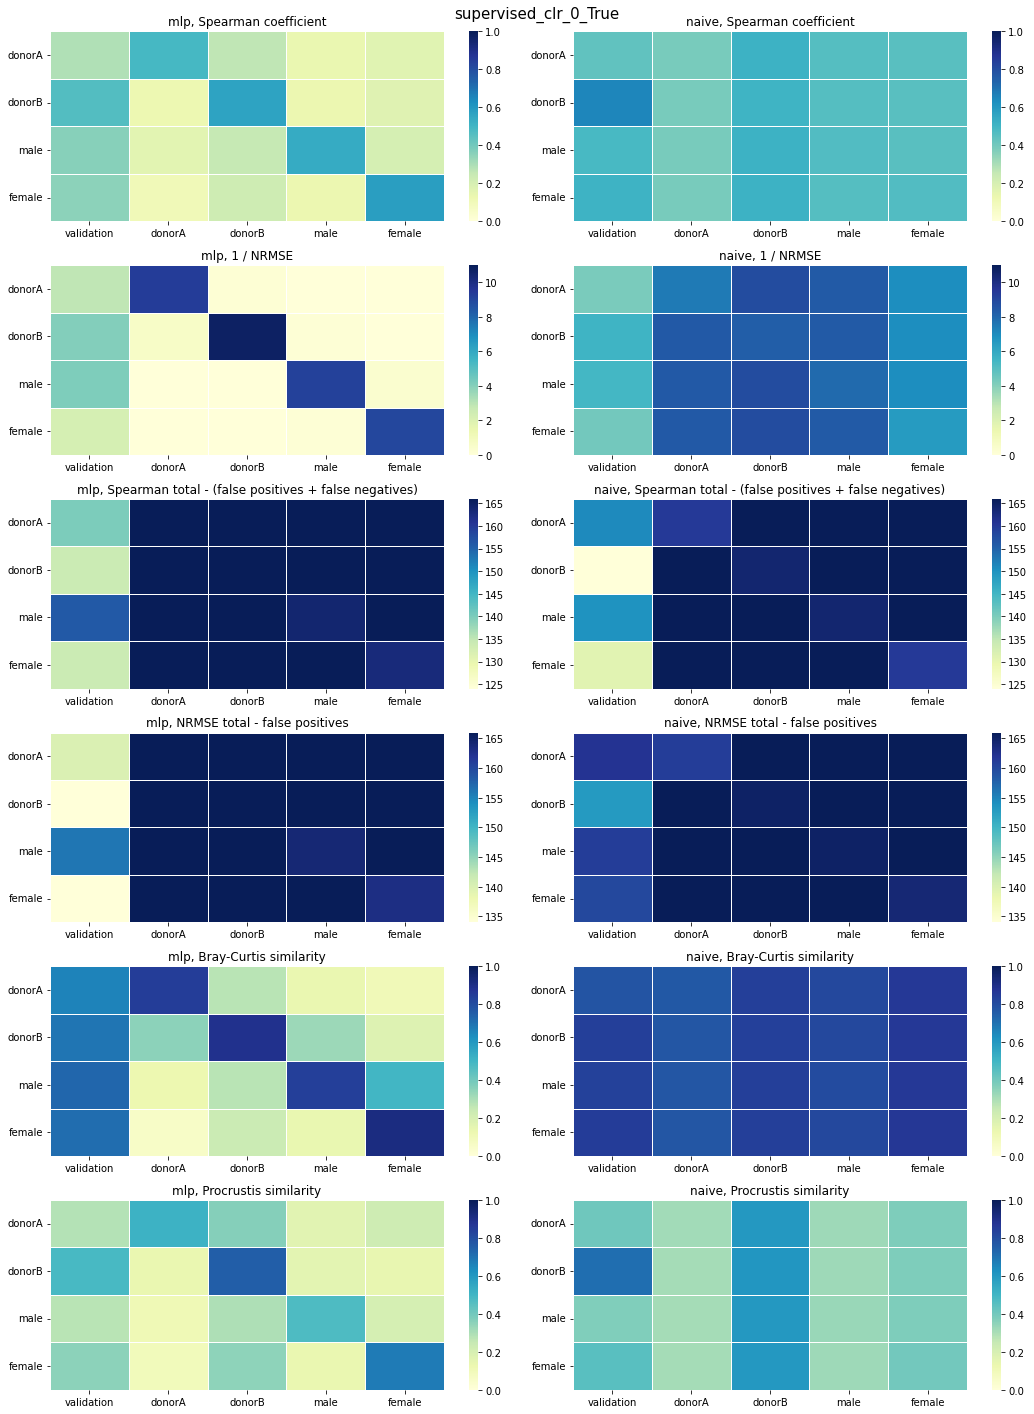

In [8]:
name = "supervised_clr_0_True"
plt.figure(figsize=(15,20))
for i, (k, v) in enumerate(plot_params.items()):
    plt.subplot(len(plot_params), 2, 2*i+1)
    # NRMSE mean / NaNs can be very different
    merged = np.concatenate([arrays[k][f'mlp_{name}'], arrays[k][f'naive_{name}']])
    if v['vmax'] == 'computed':
        vmax = np.ceil(np.max(merged))
    else:
        vmax = v['vmax']
    # NRMSE NaNs can be very different
    if v['vmin'] == 'computed':
        vmin = np.min(merged)
    else:
        vmin = v['vmin']
    ax = sns.heatmap(arrays[k][f'mlp_{name}'], vmin=vmin, vmax=vmax, **kwargs)
    ax.tick_params(axis='y', rotation=0)
    ax.set_title(f'mlp, {v["label"]}')
    plt.subplot(len(plot_params), 2, 2*i+2)
    ax = sns.heatmap(arrays[k][f'naive_{name}'], vmin=vmin, vmax=vmax, **kwargs)
    ax.tick_params(axis='y', rotation=0)
    ax.set_title(f'naive, {v["label"]}')
plt.suptitle(name, fontsize=15)
plt.tight_layout()
# plt.savefig(PLOT_PATH / f"{name}.png", dpi=200, facecolor='white')
plt.show()

### Loop

/tmp/ipykernel_1180802/561809161.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15,20))


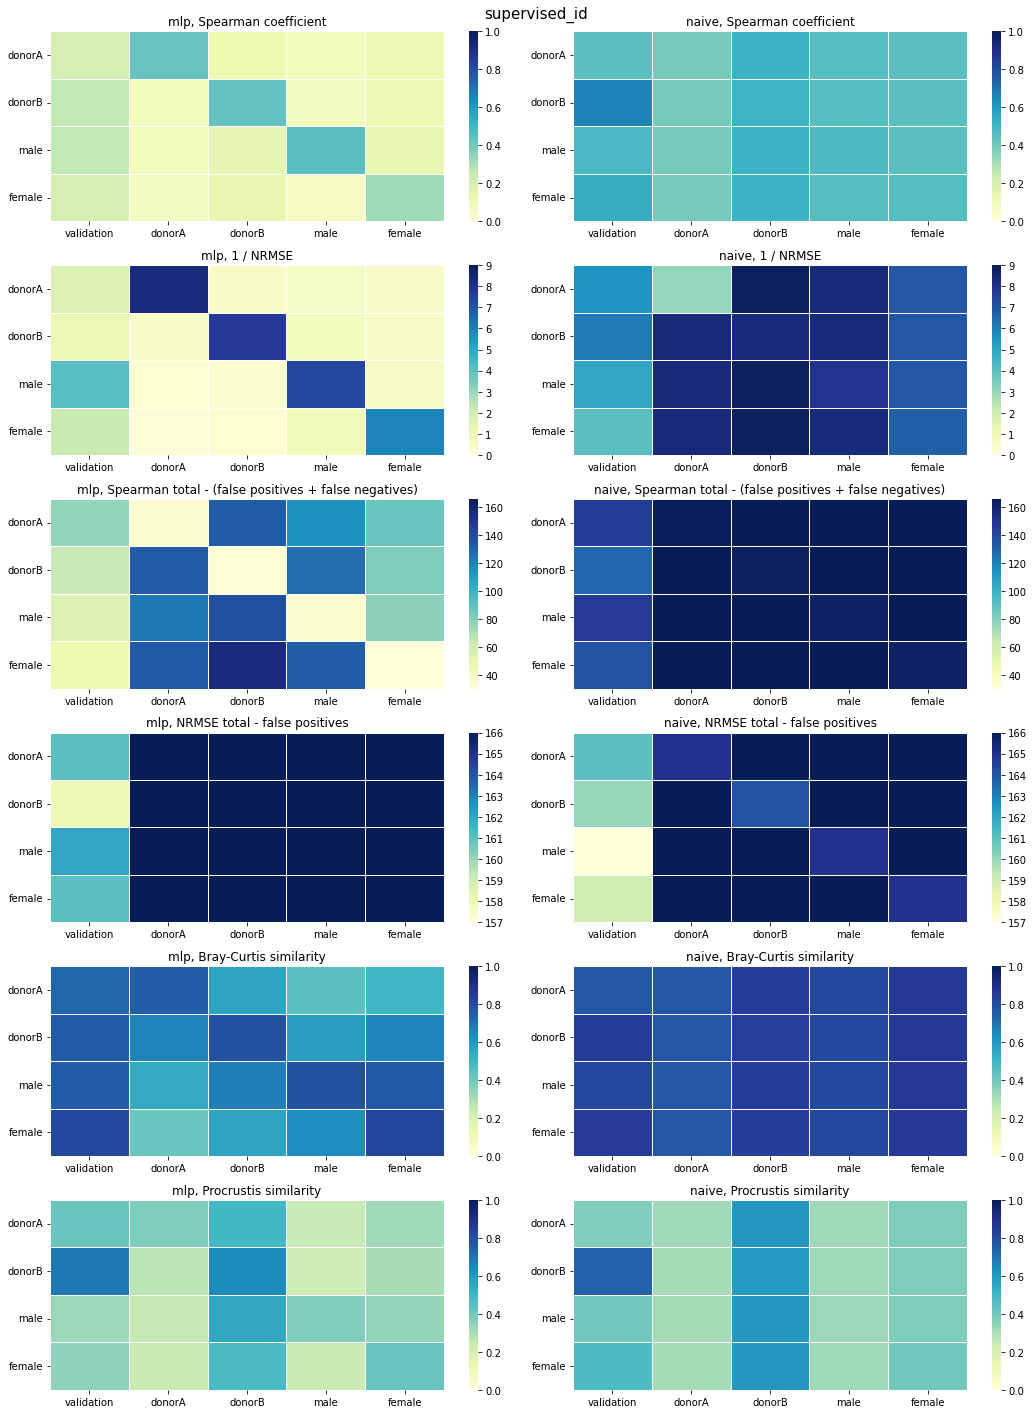

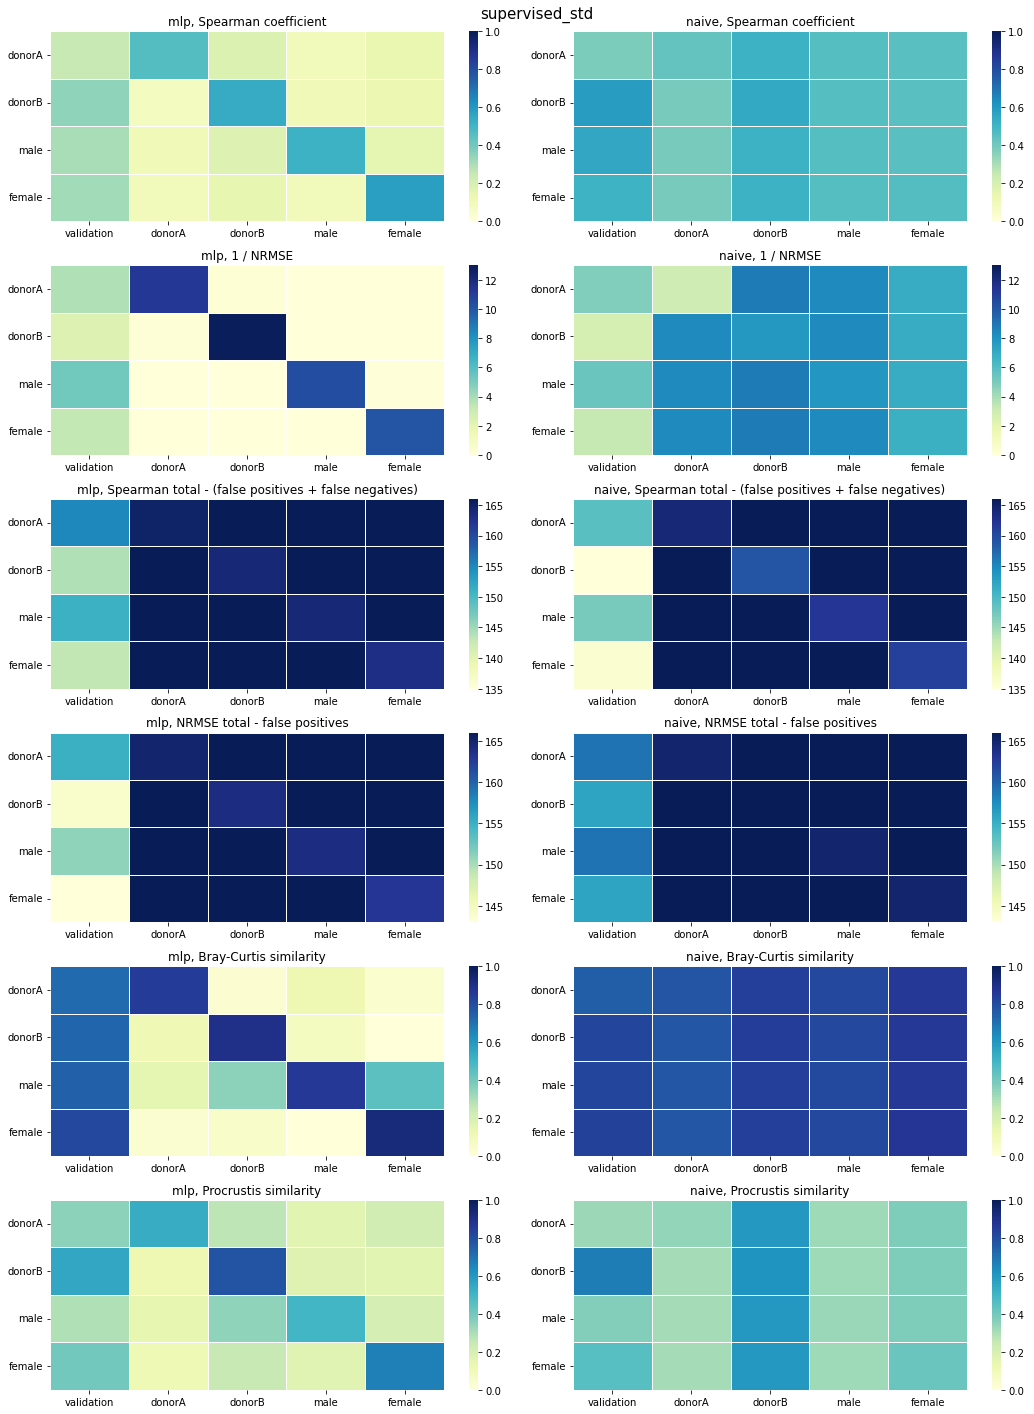

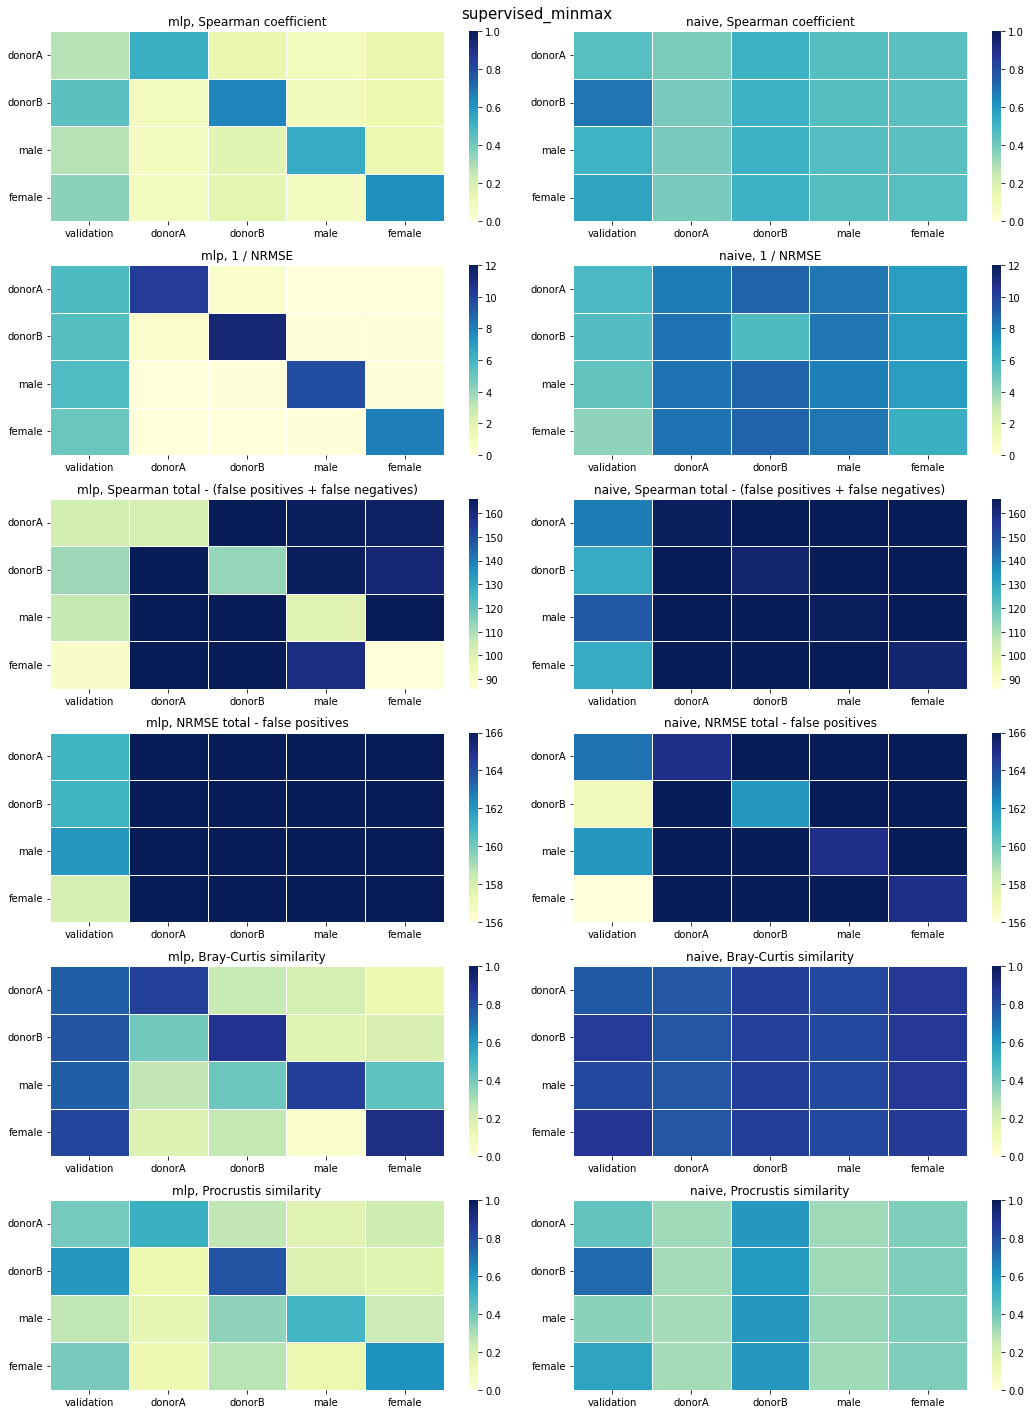

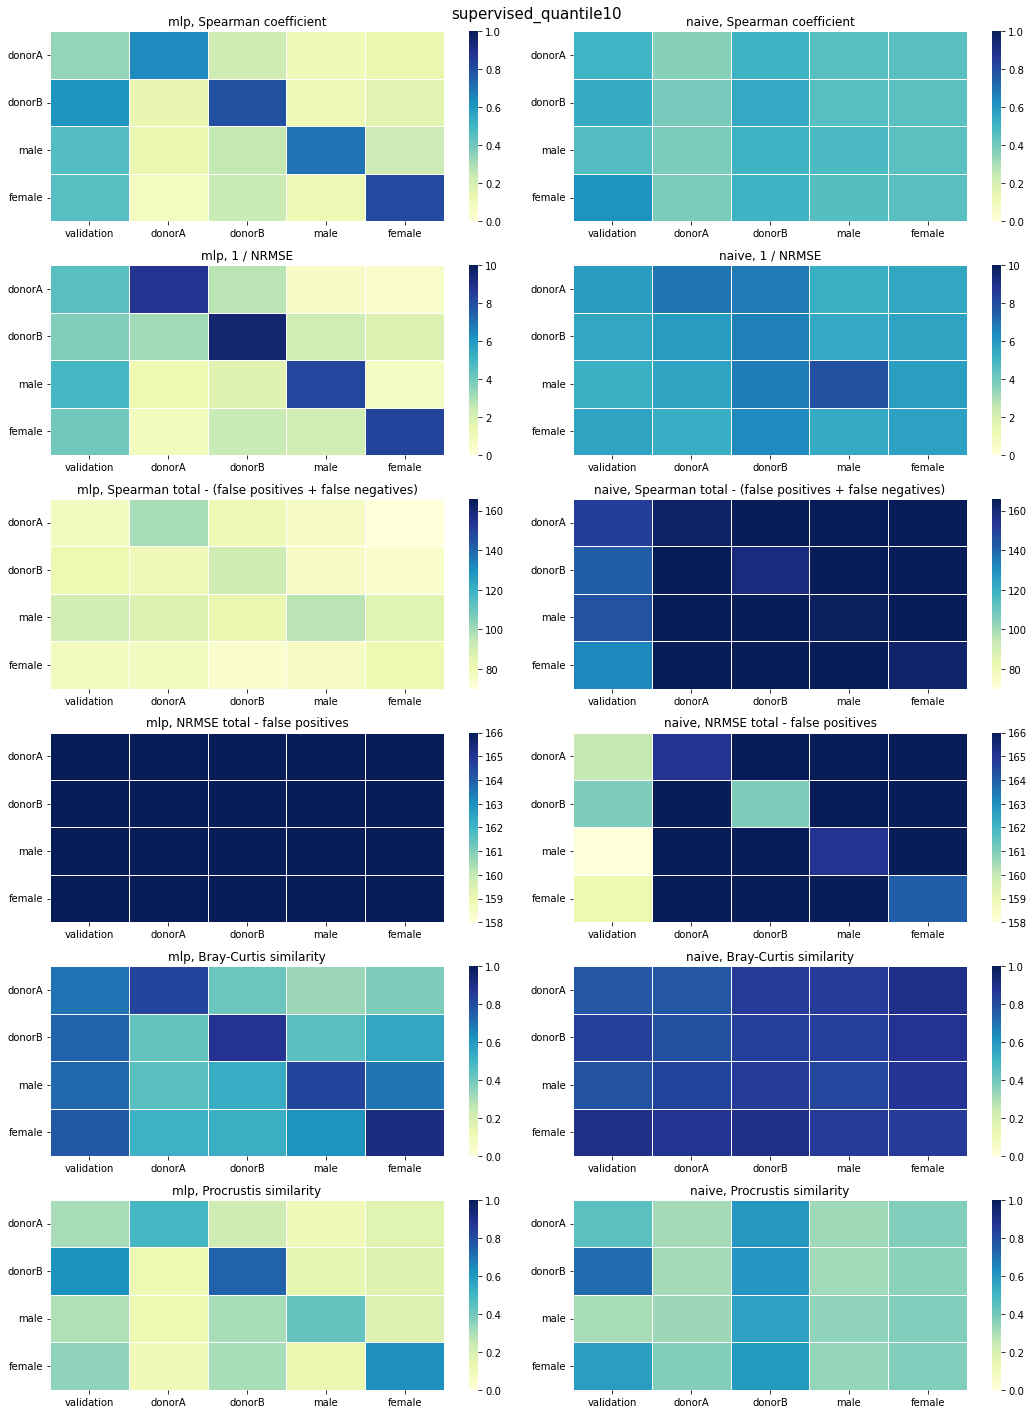

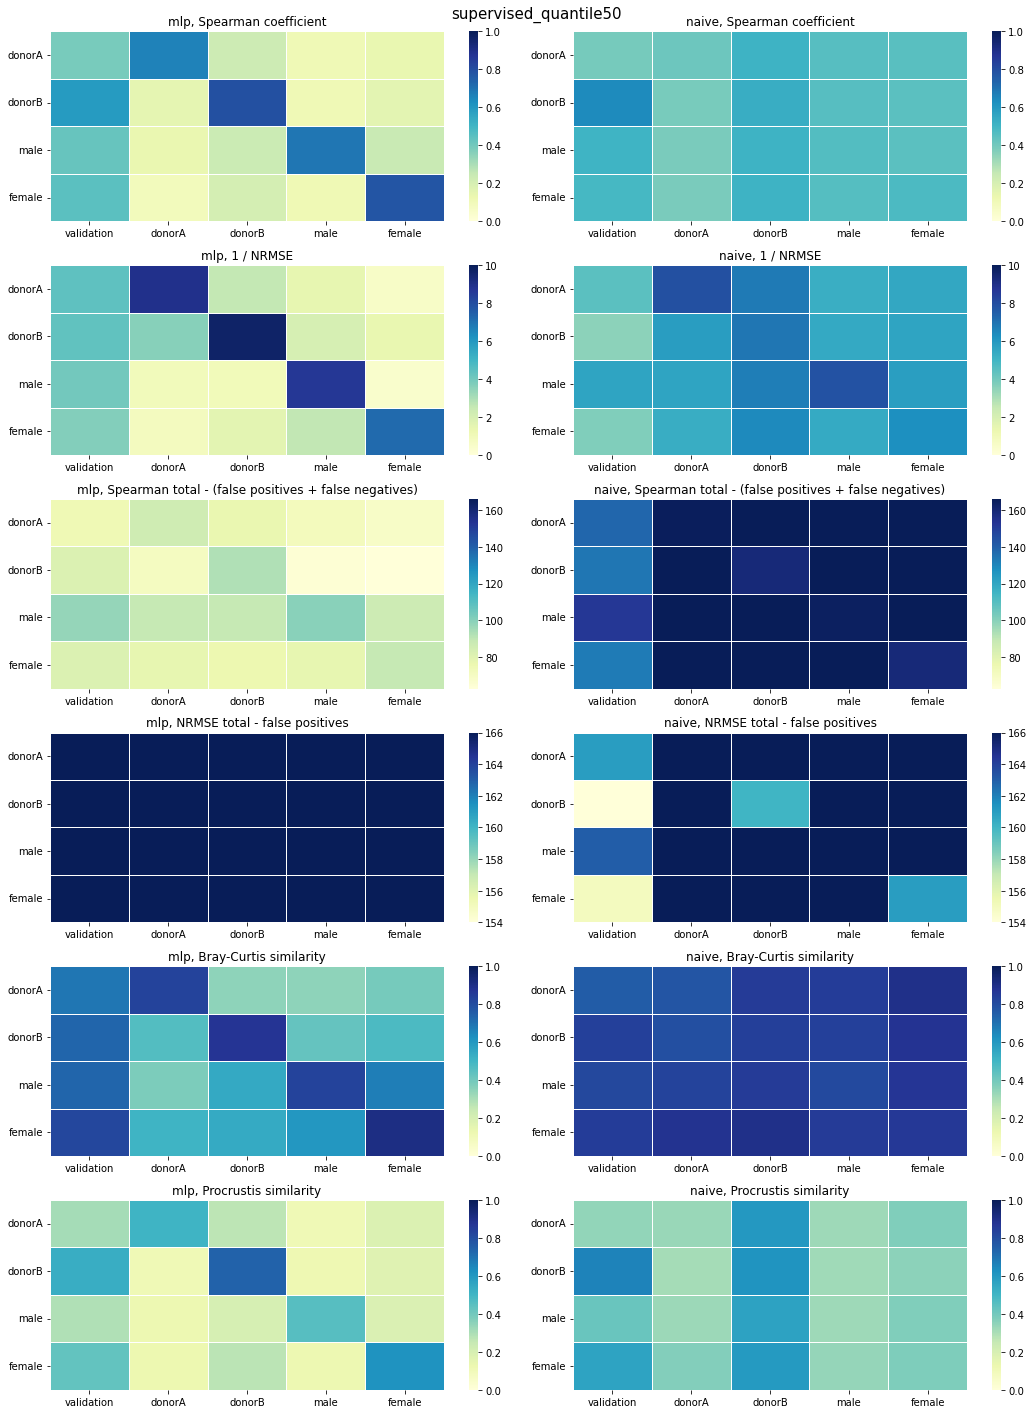

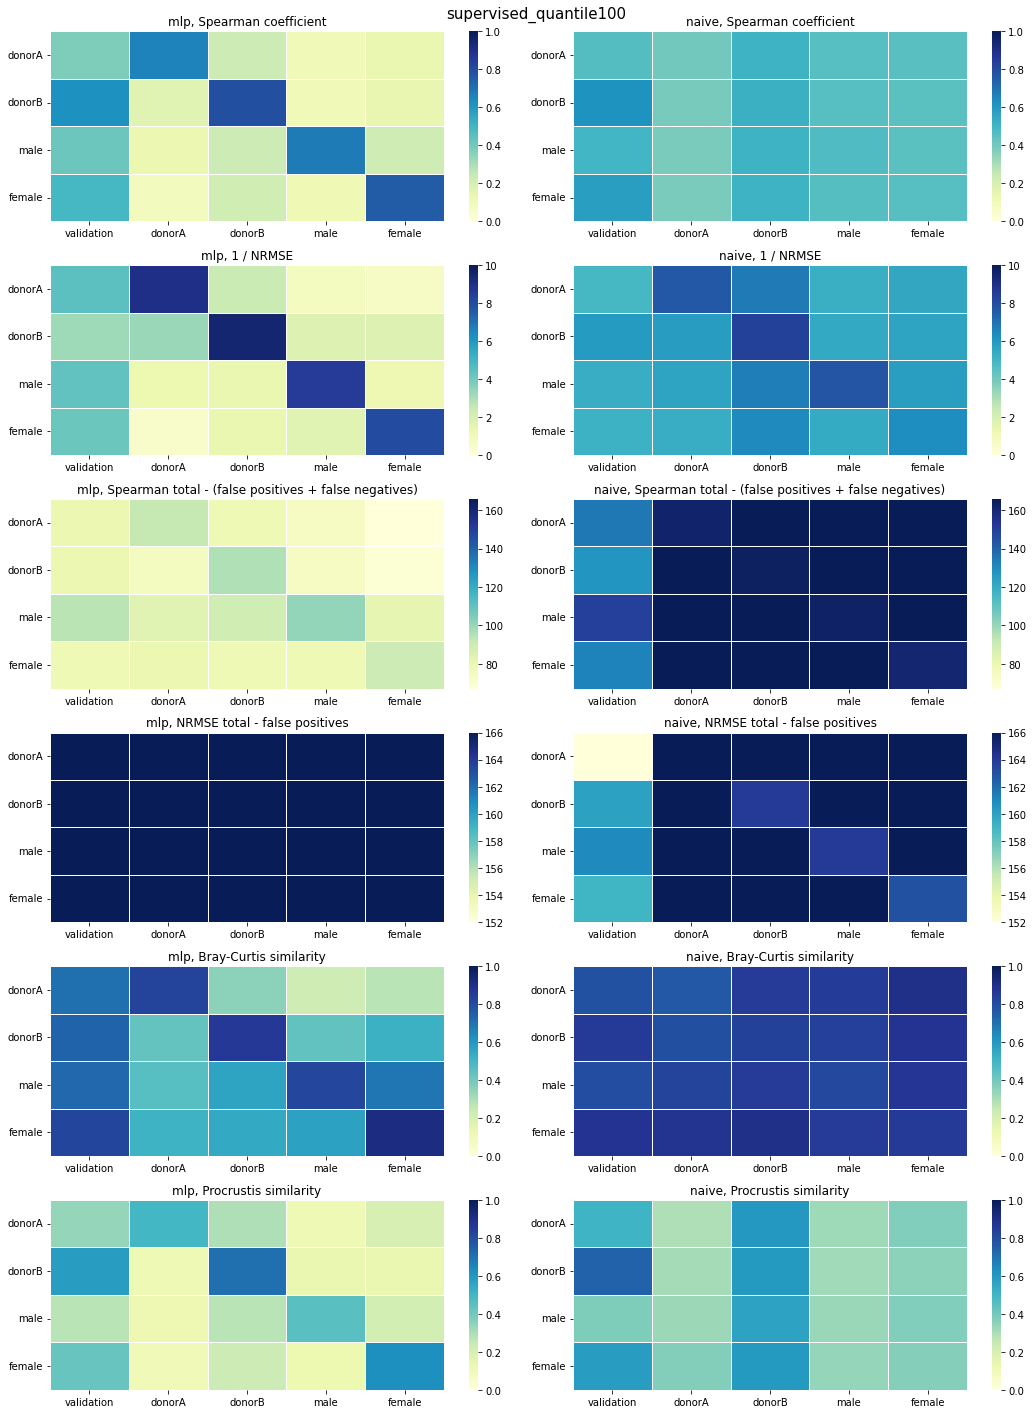

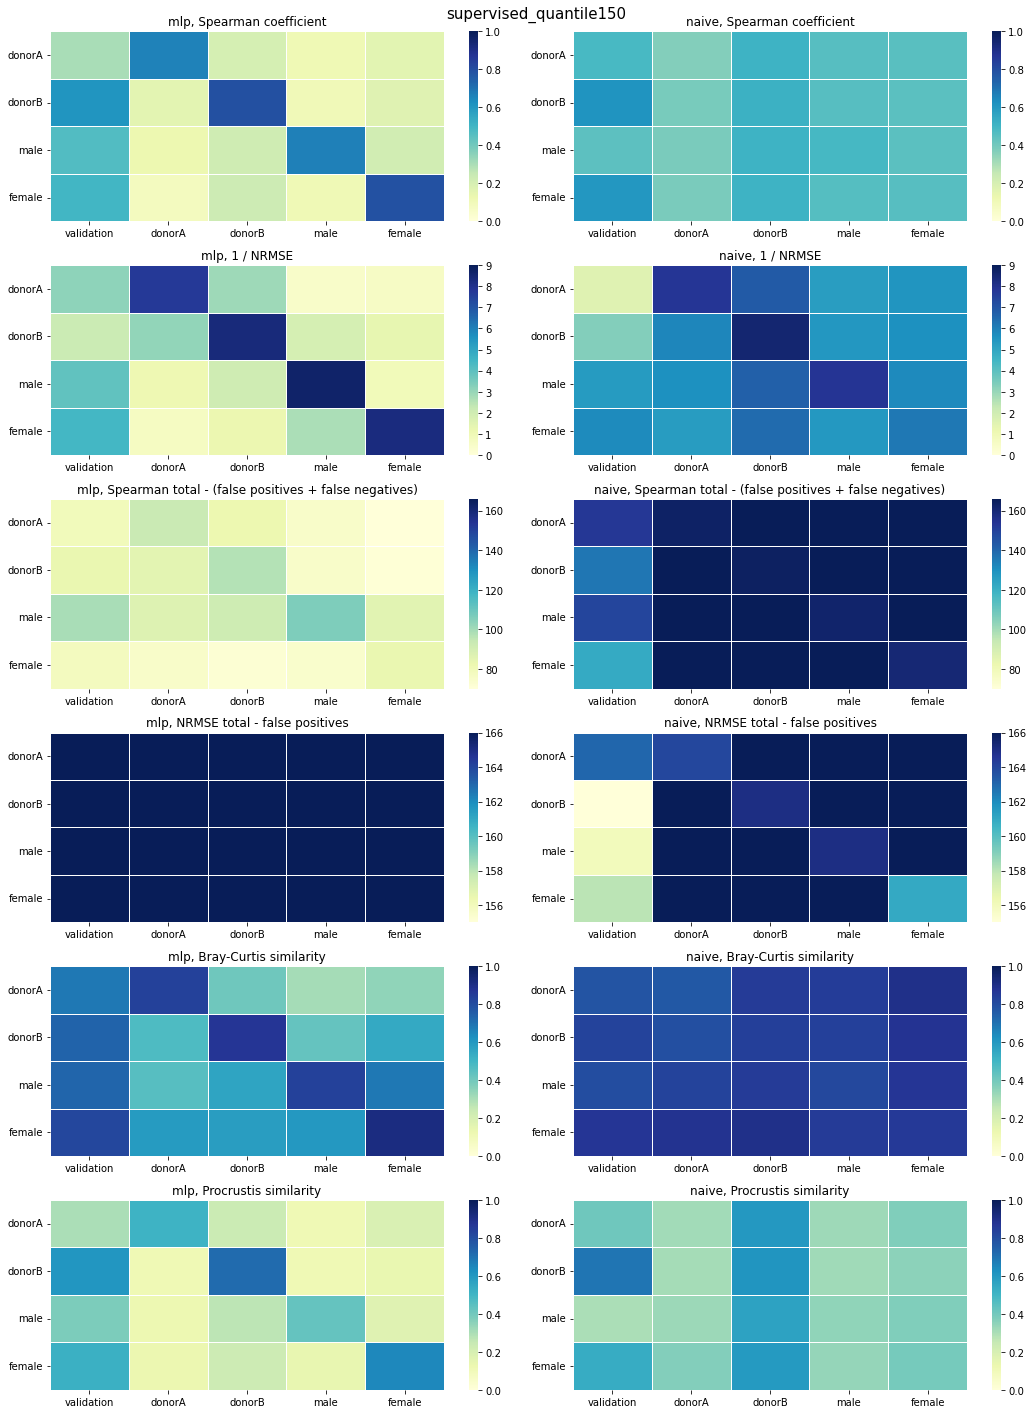

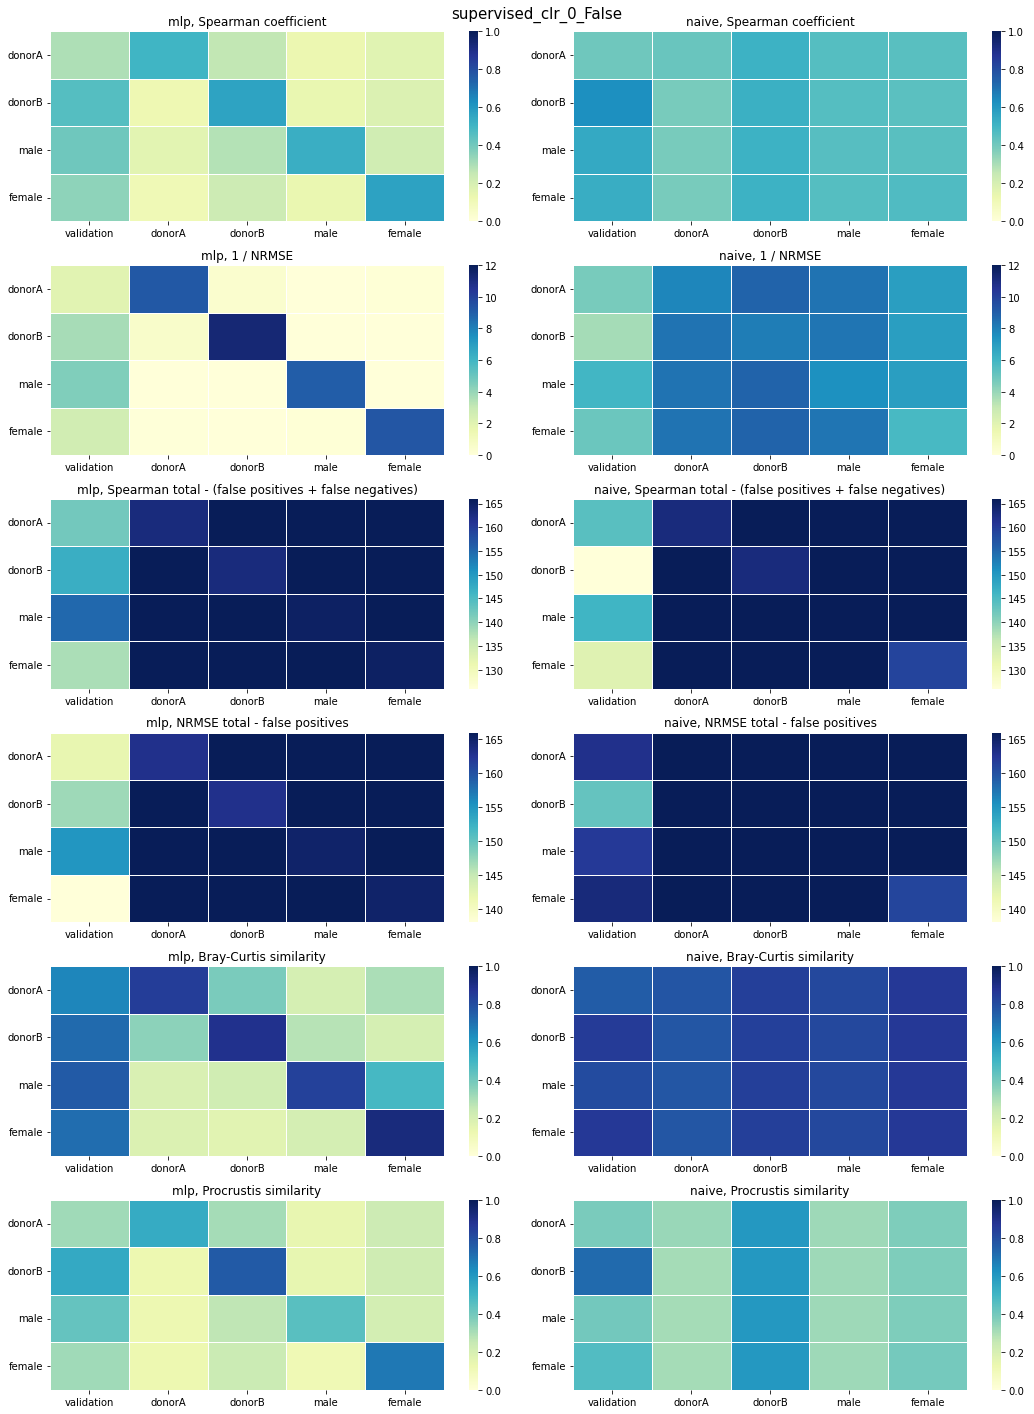

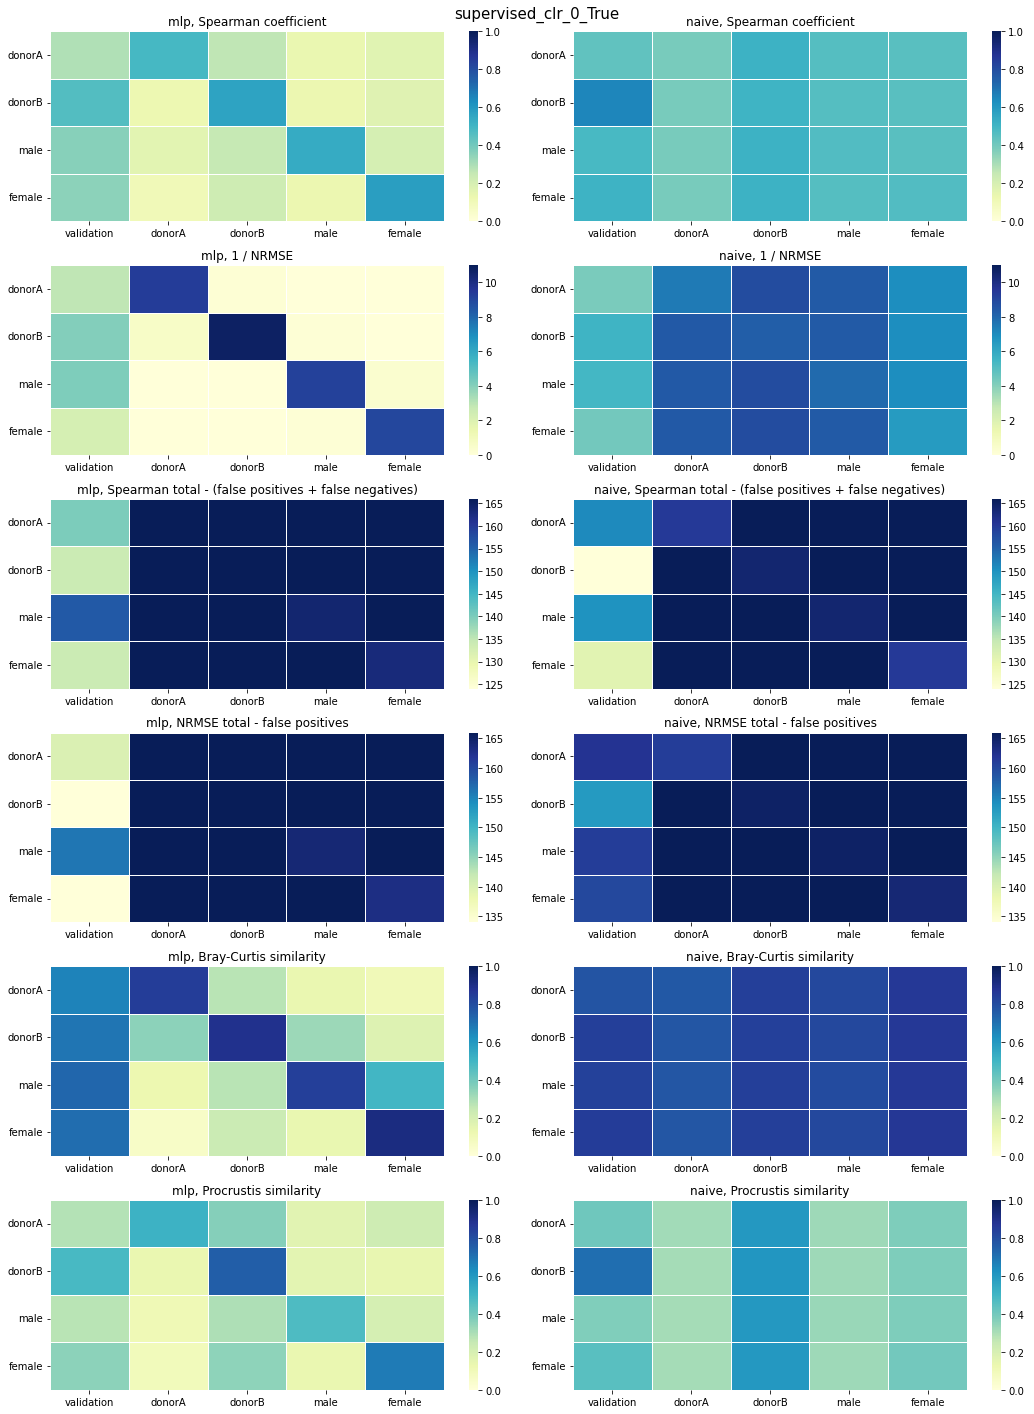

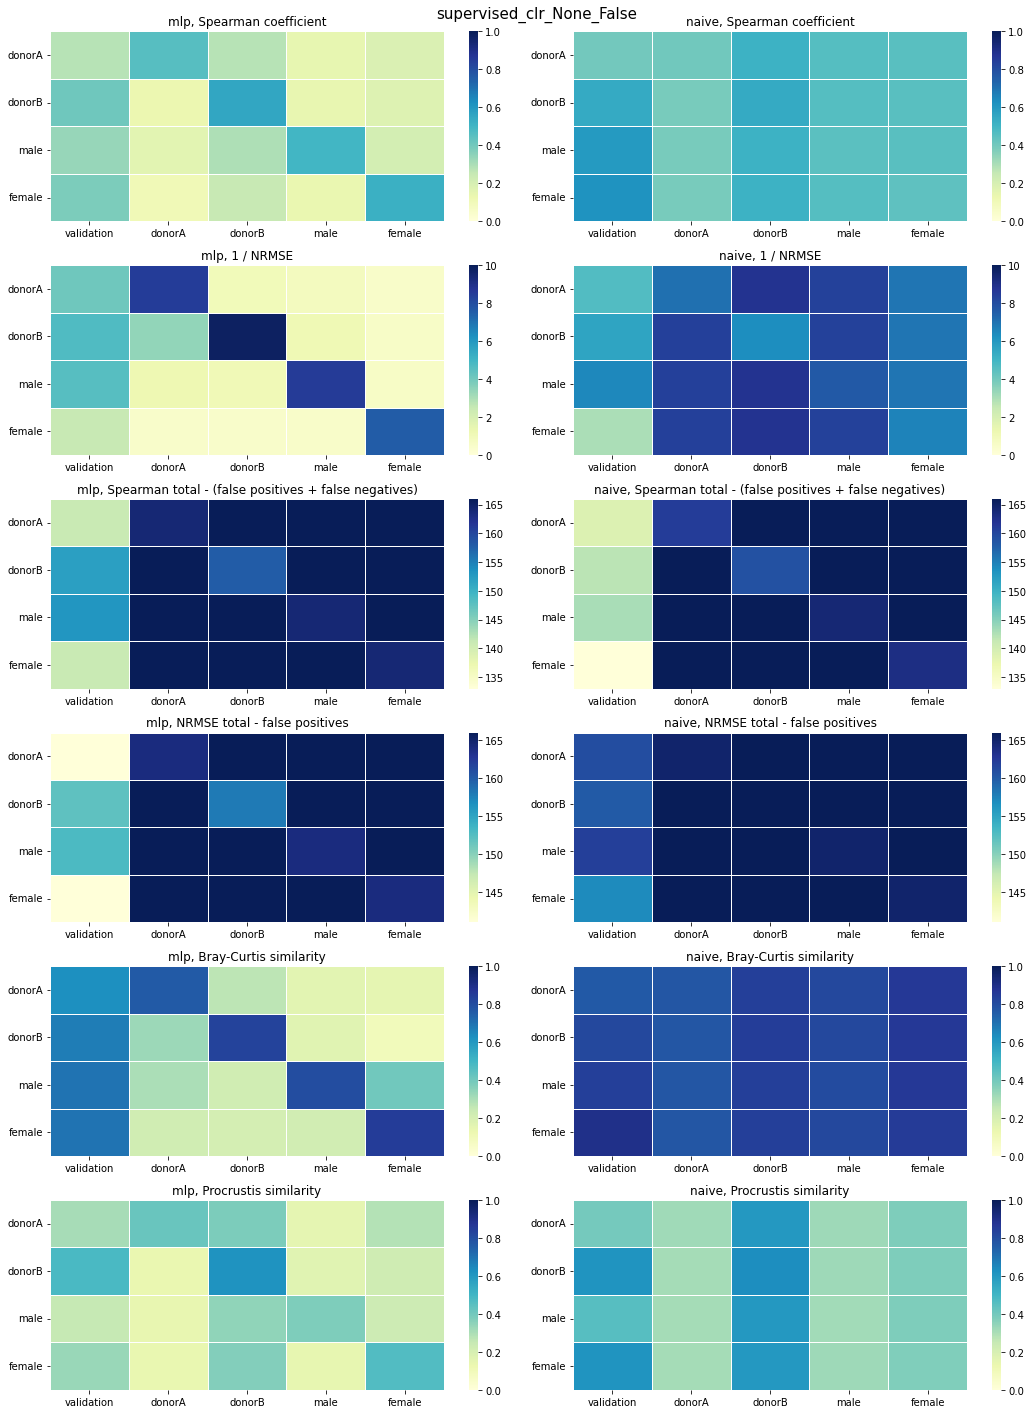

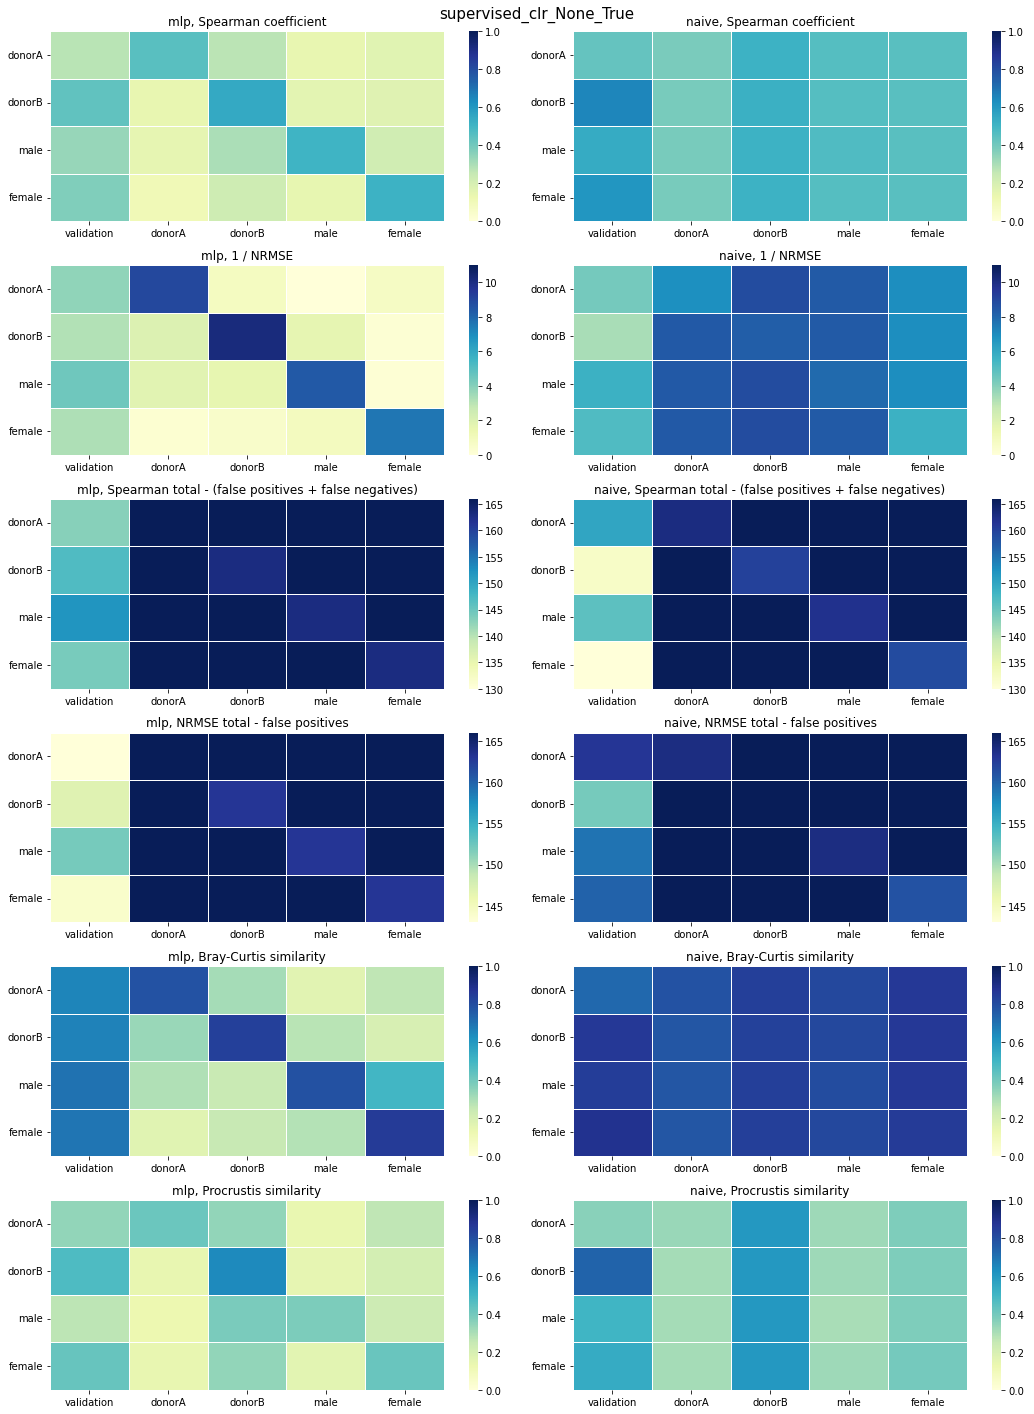

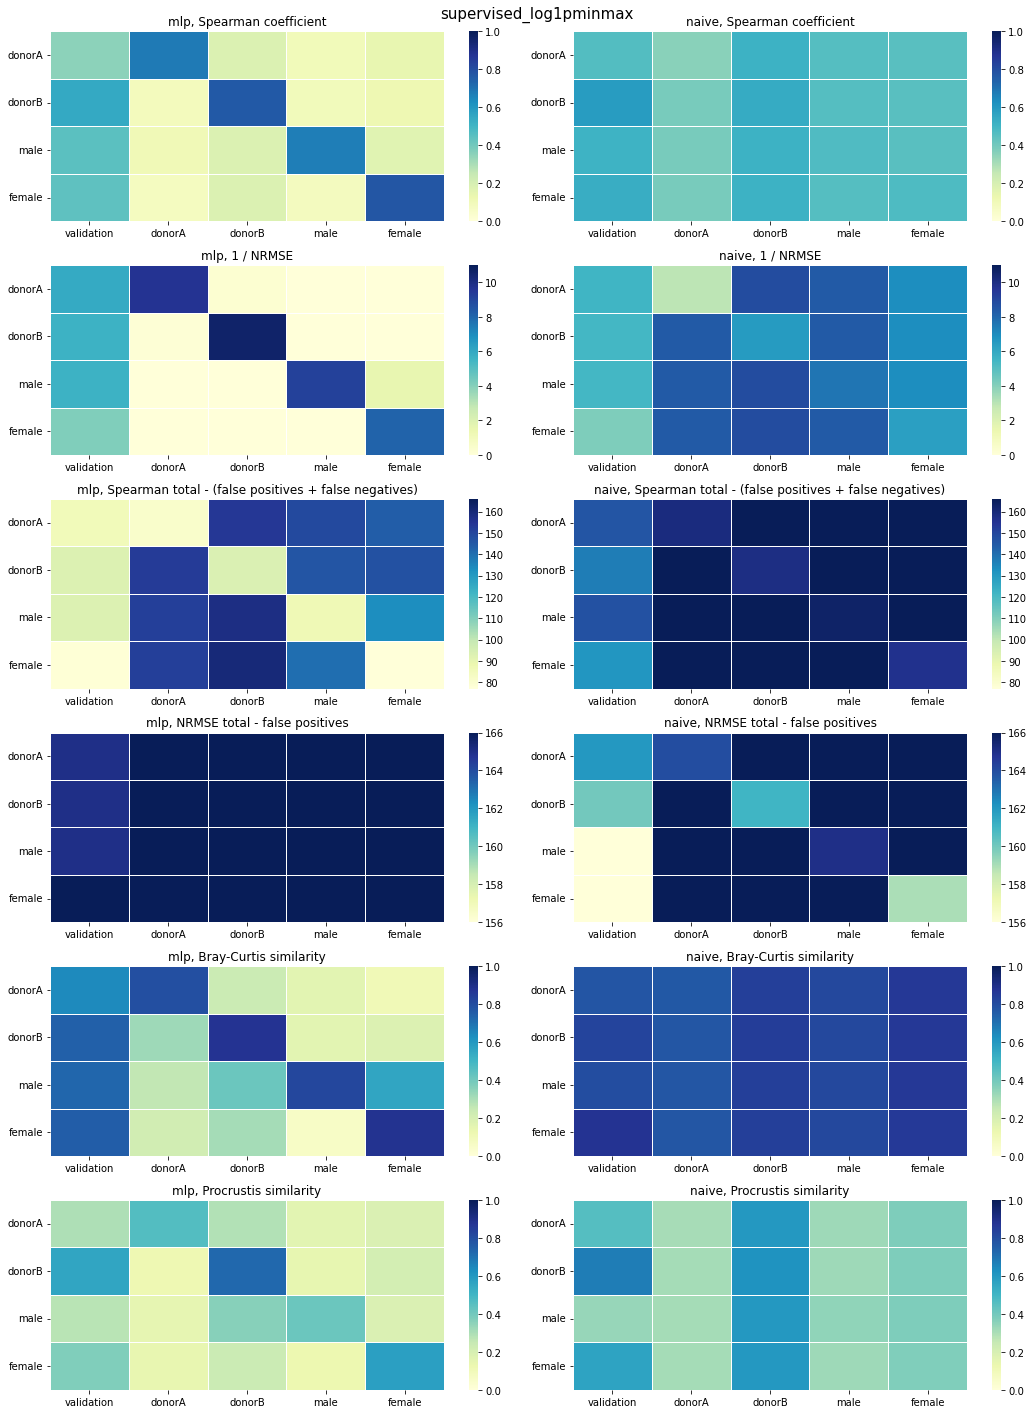

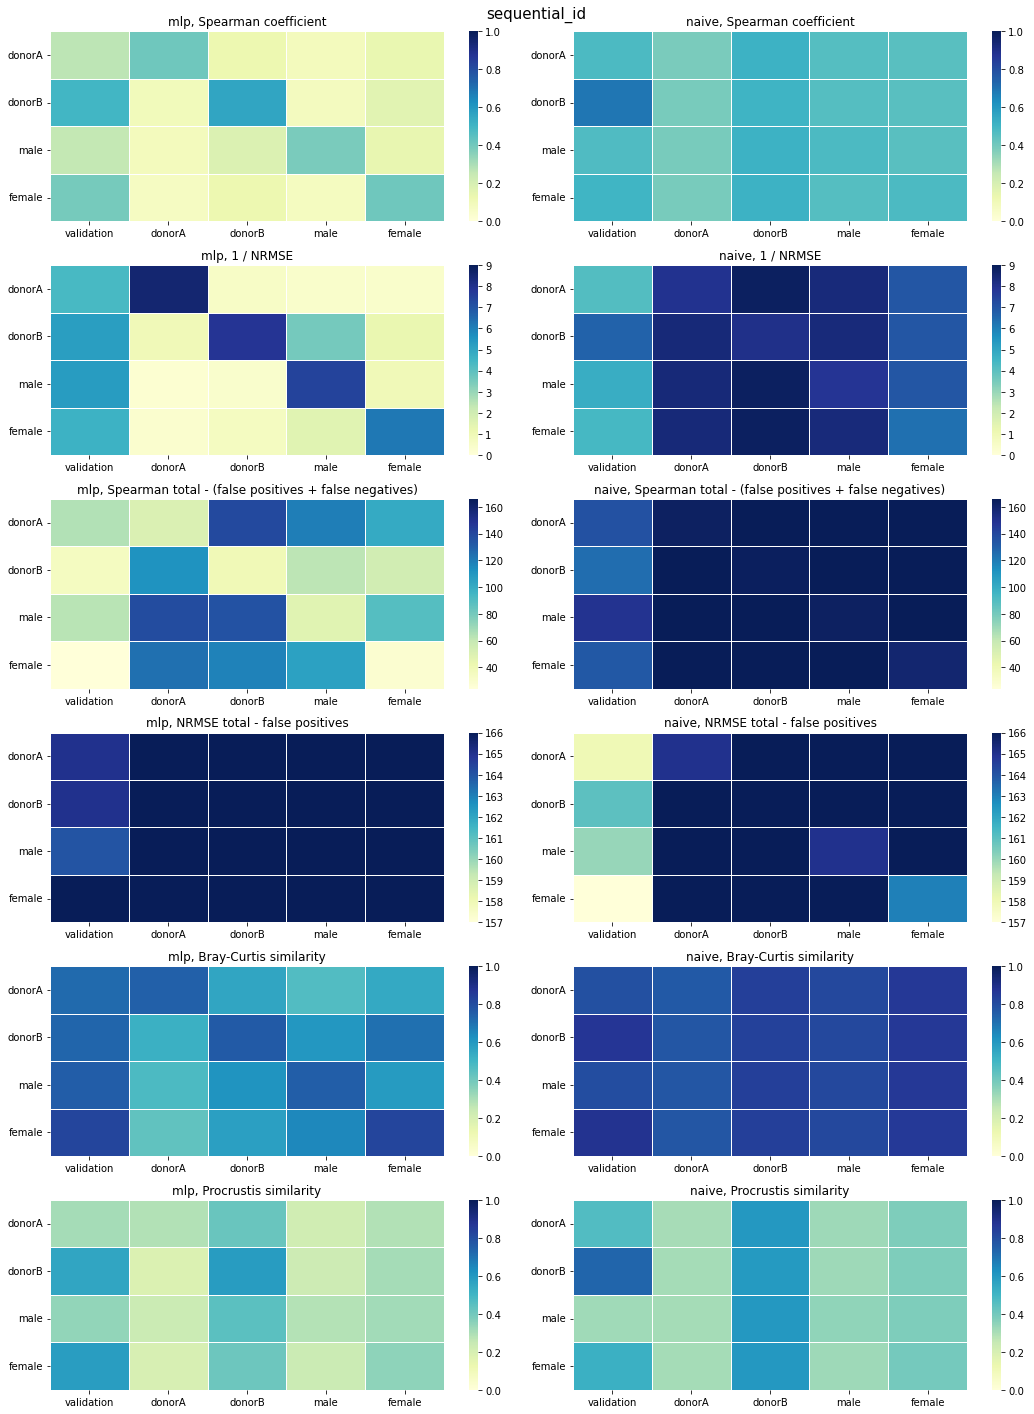

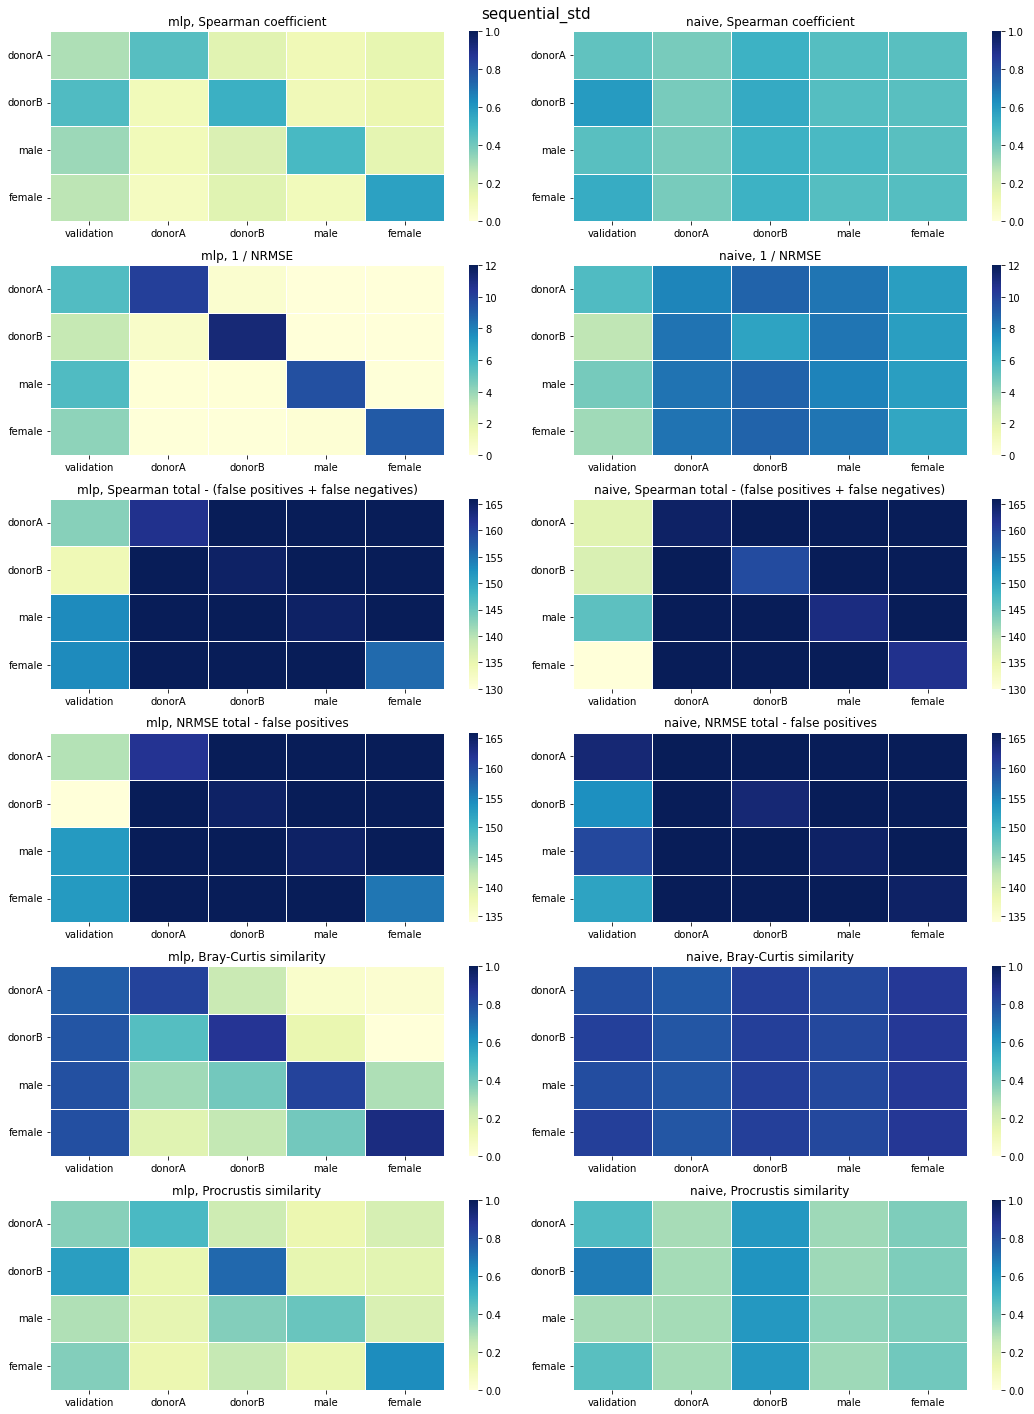

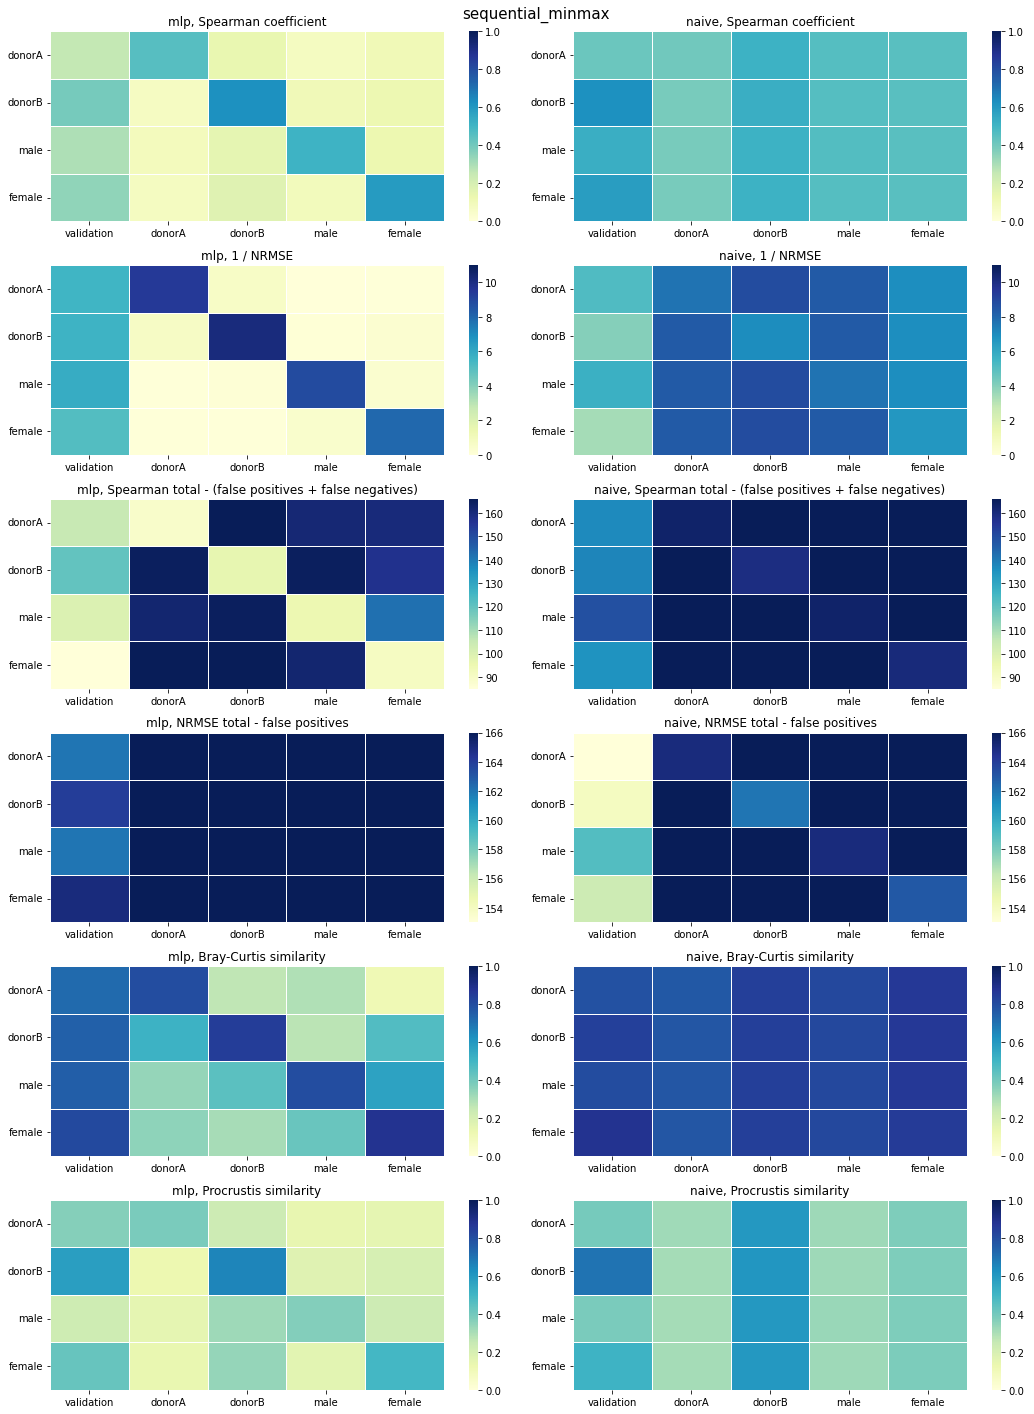

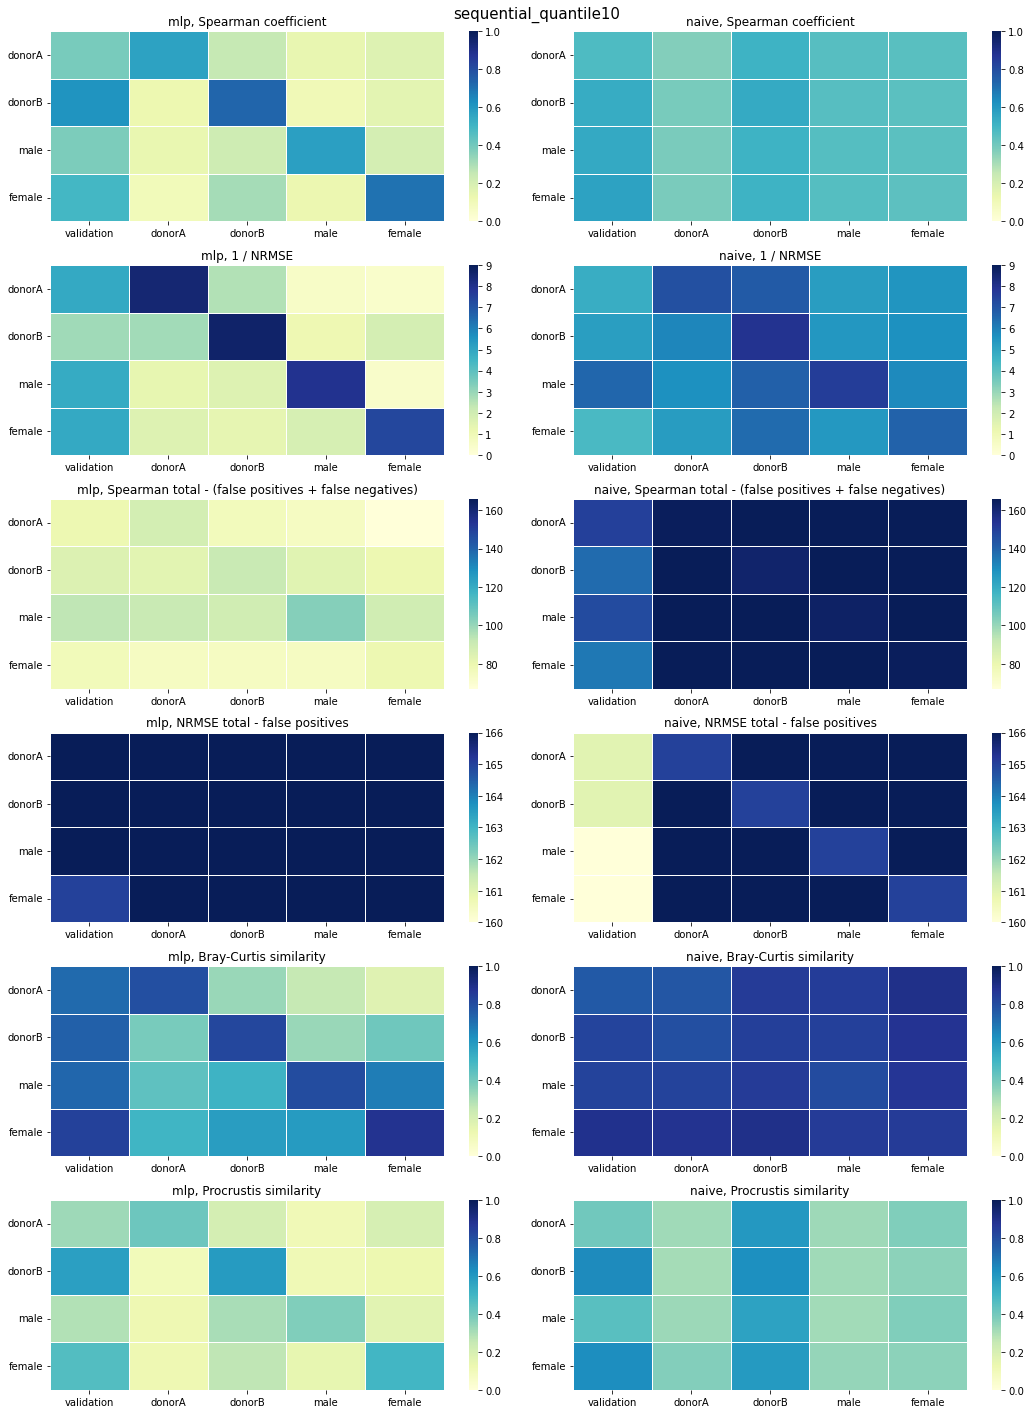

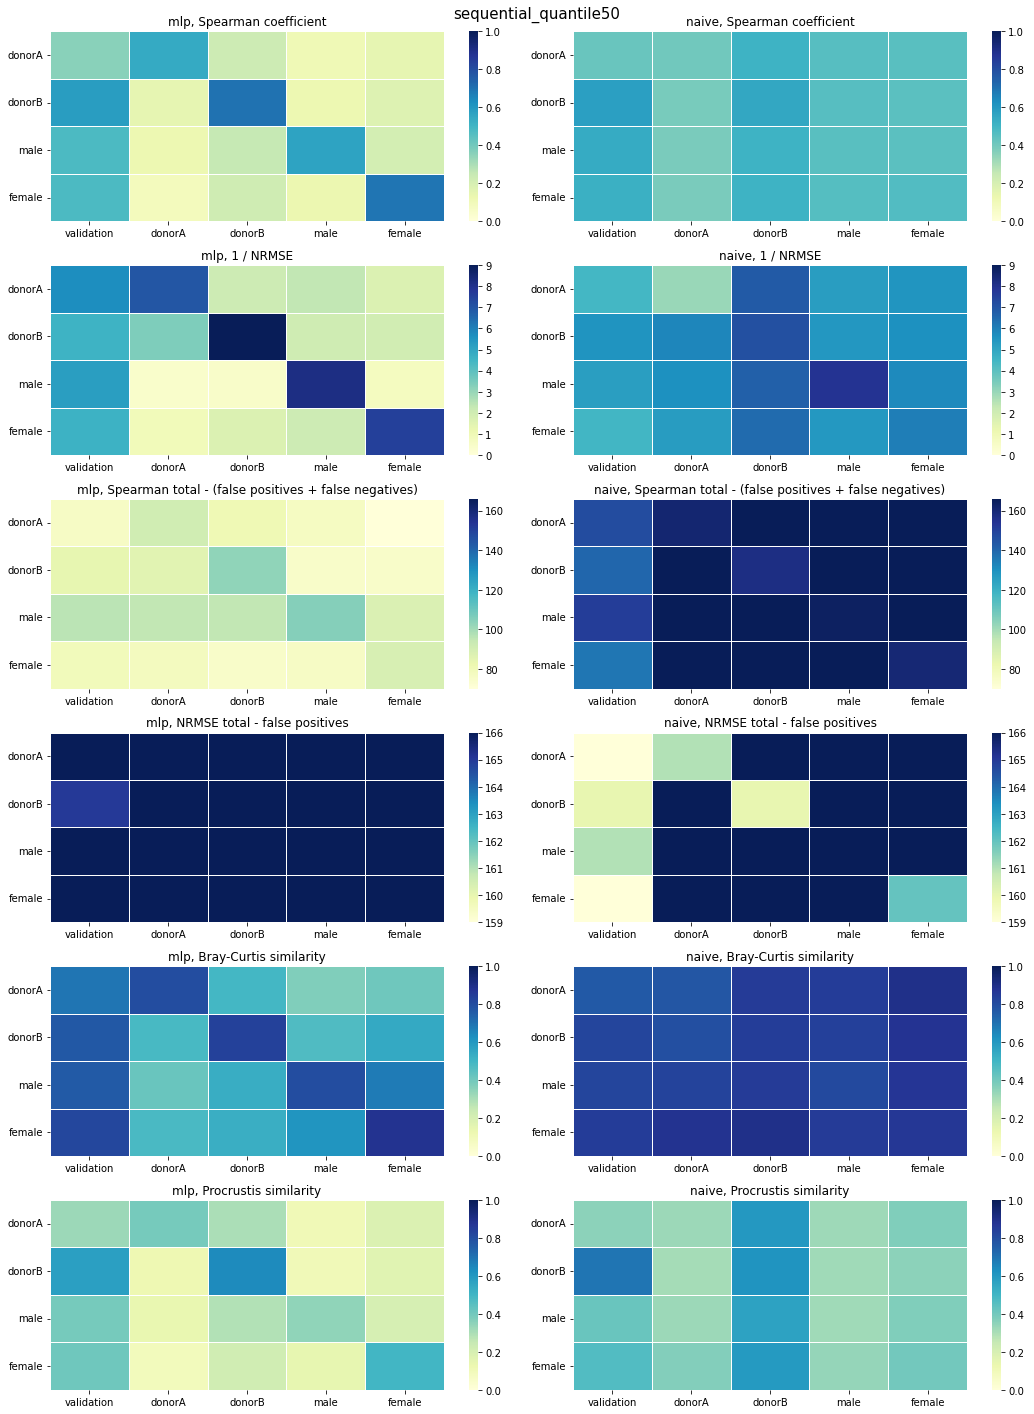

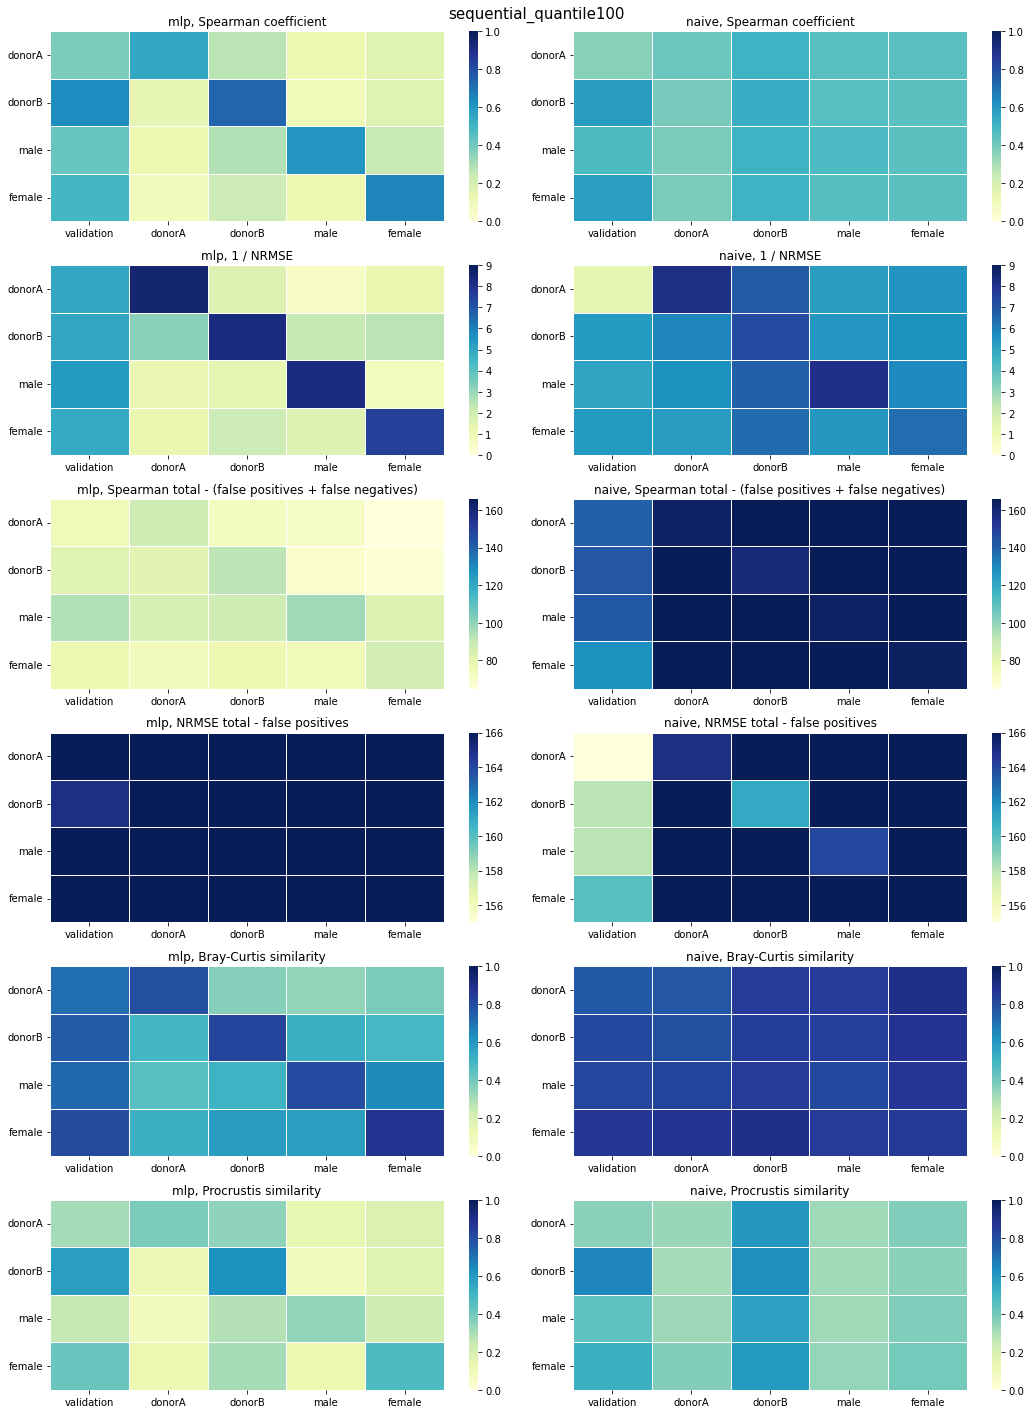

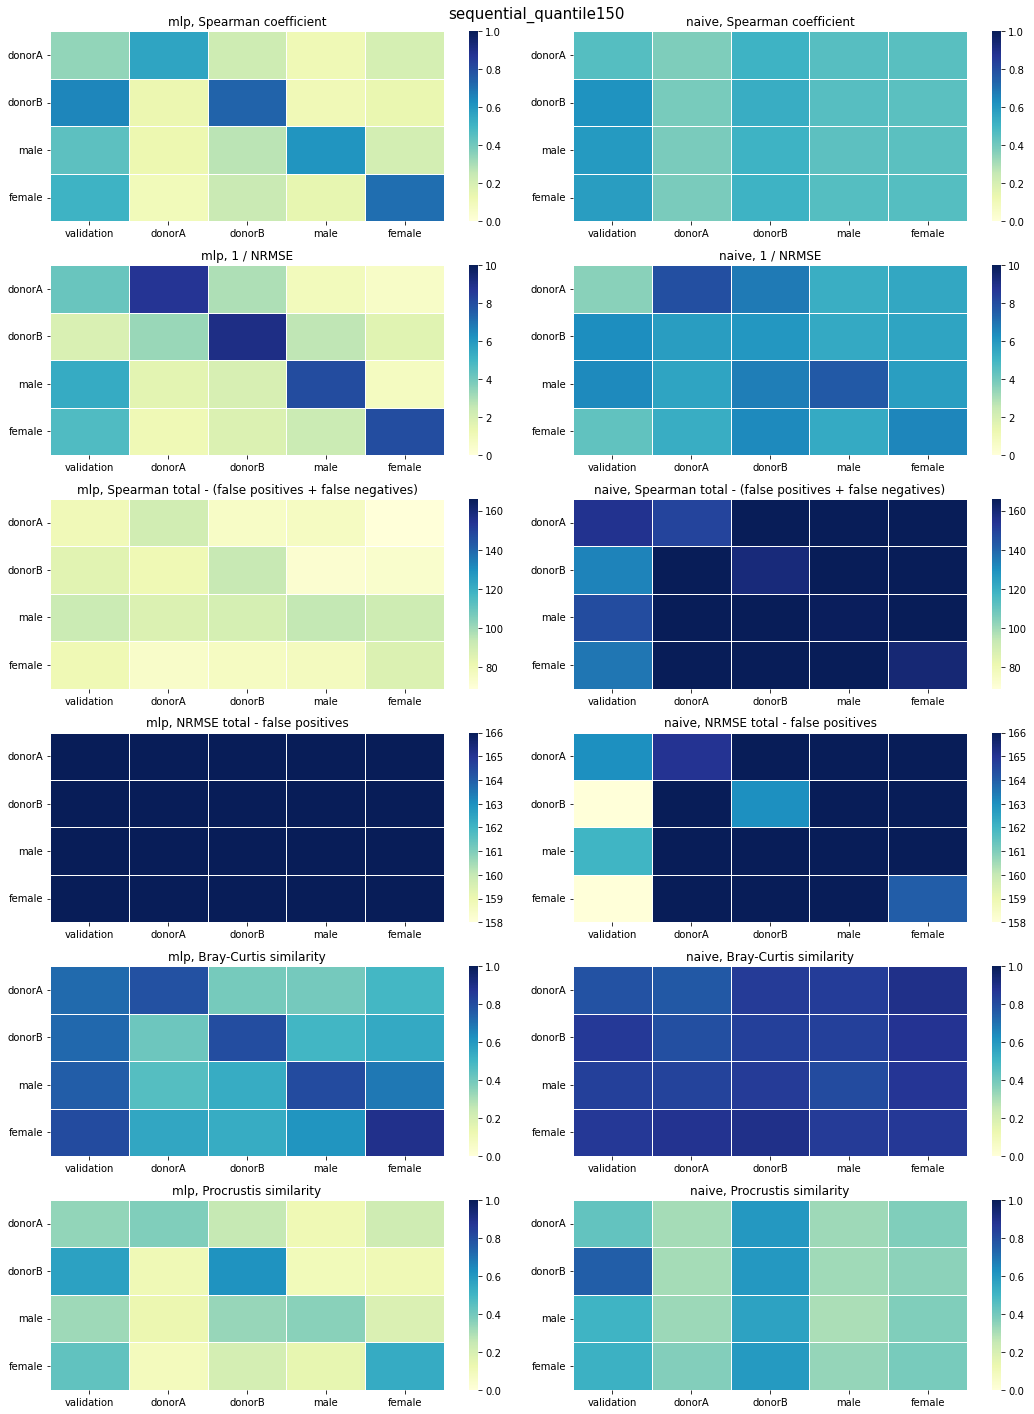

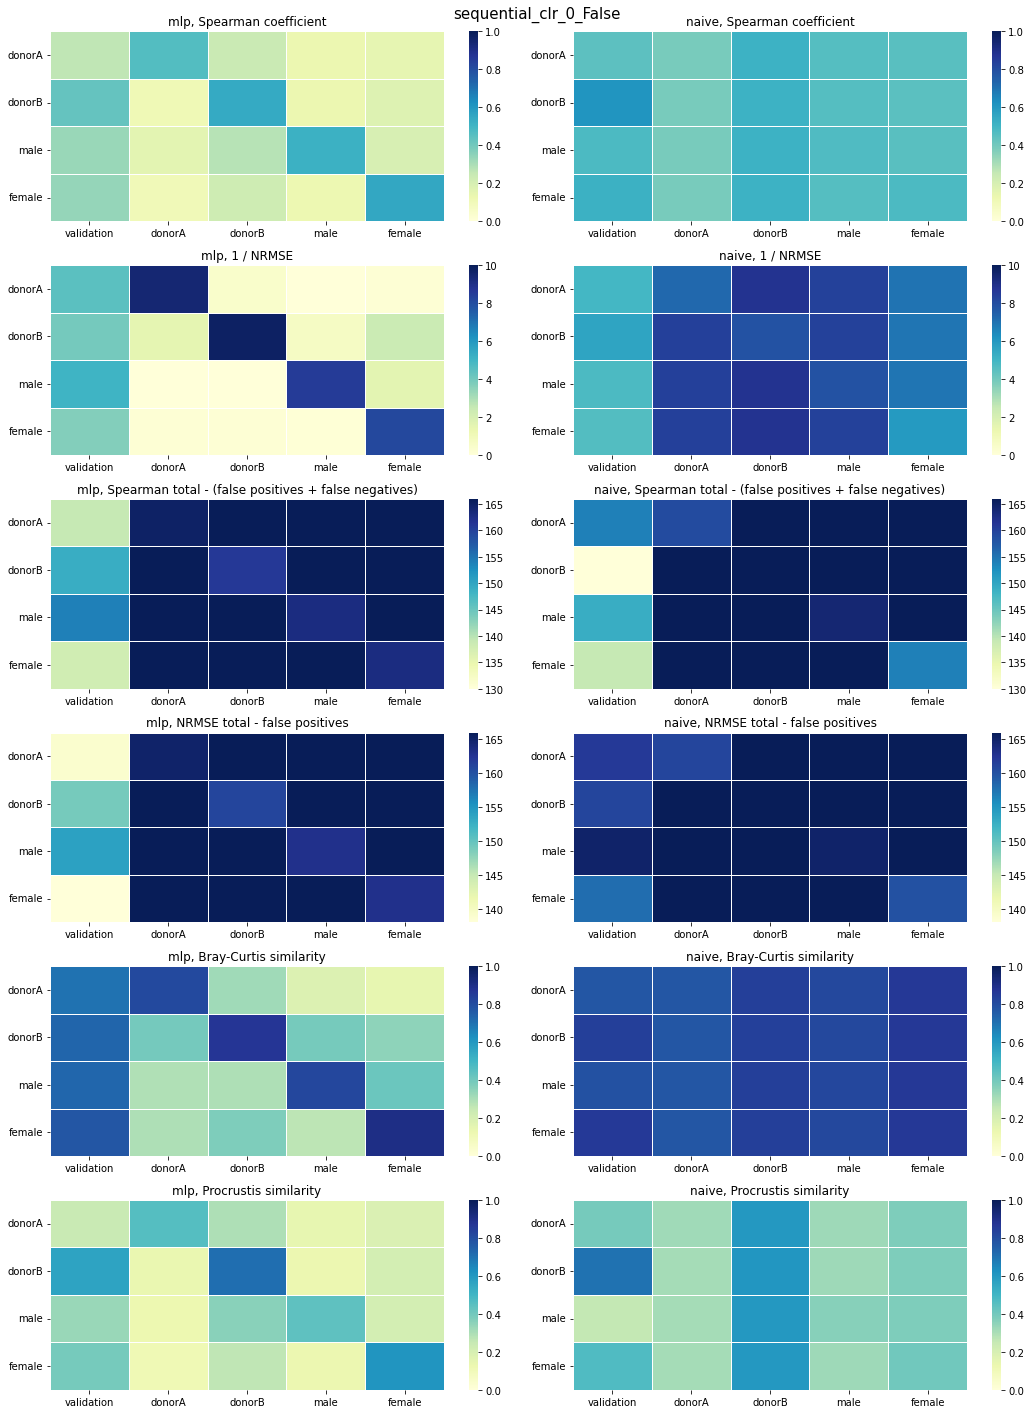

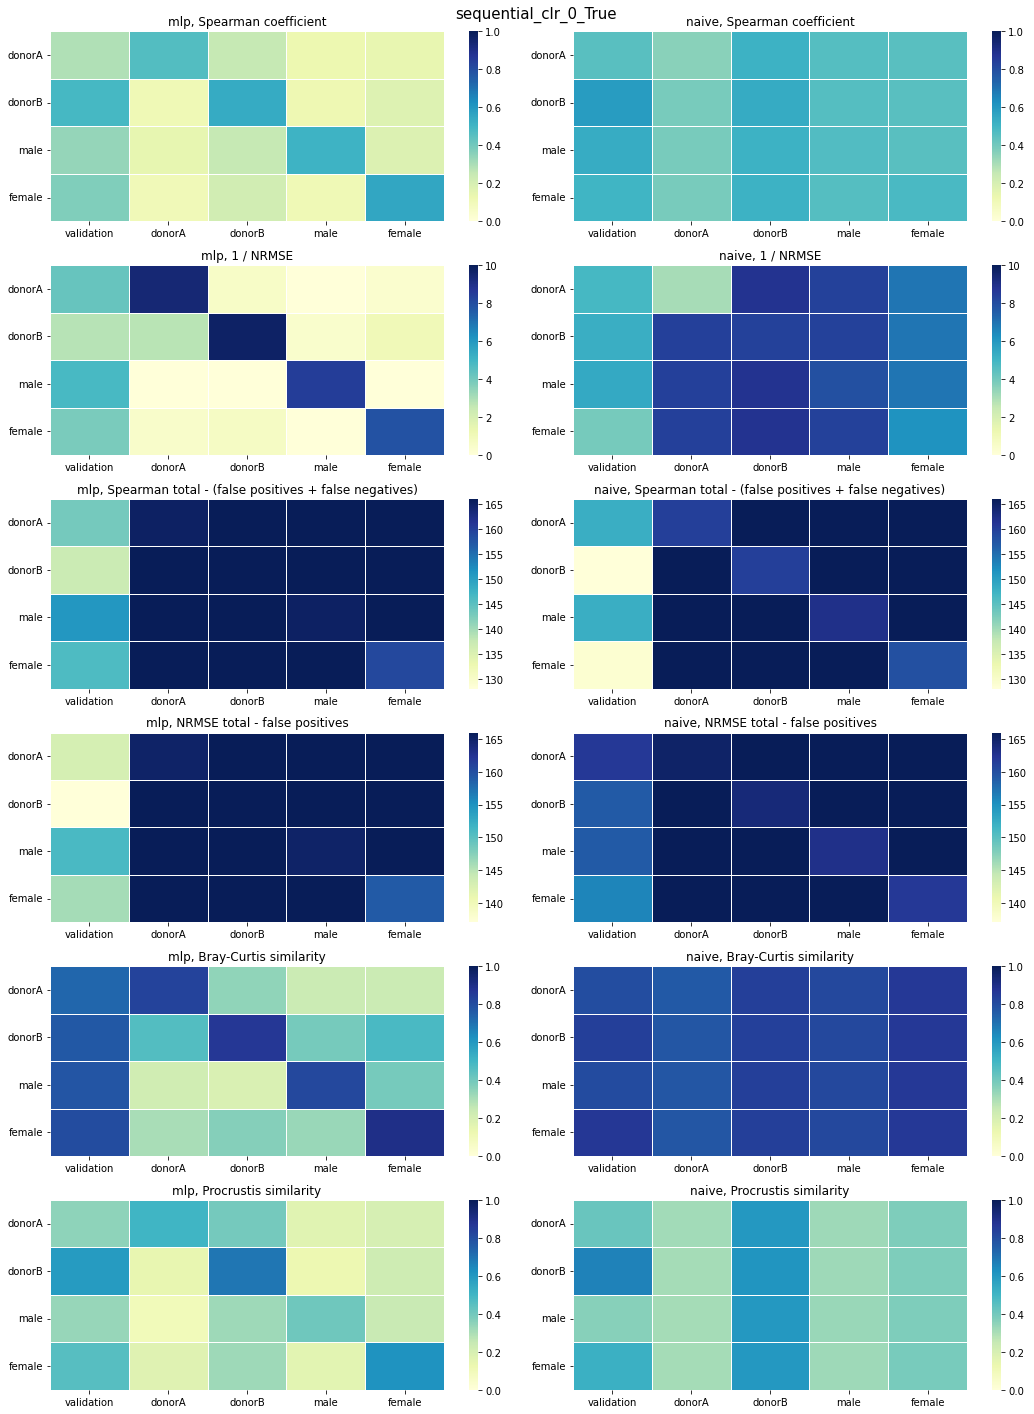

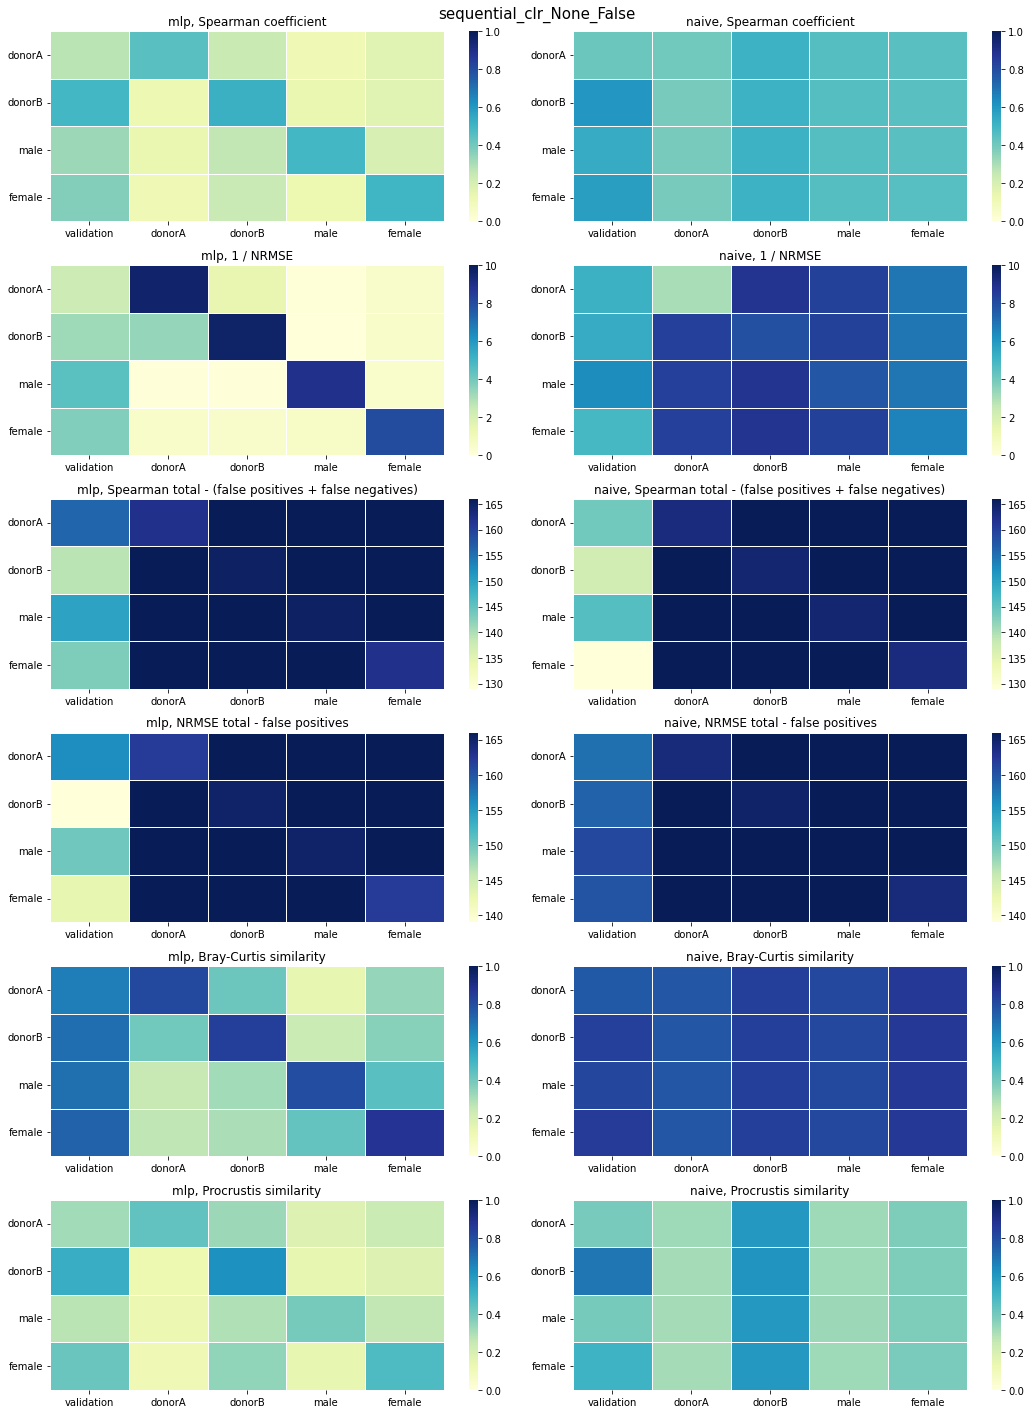

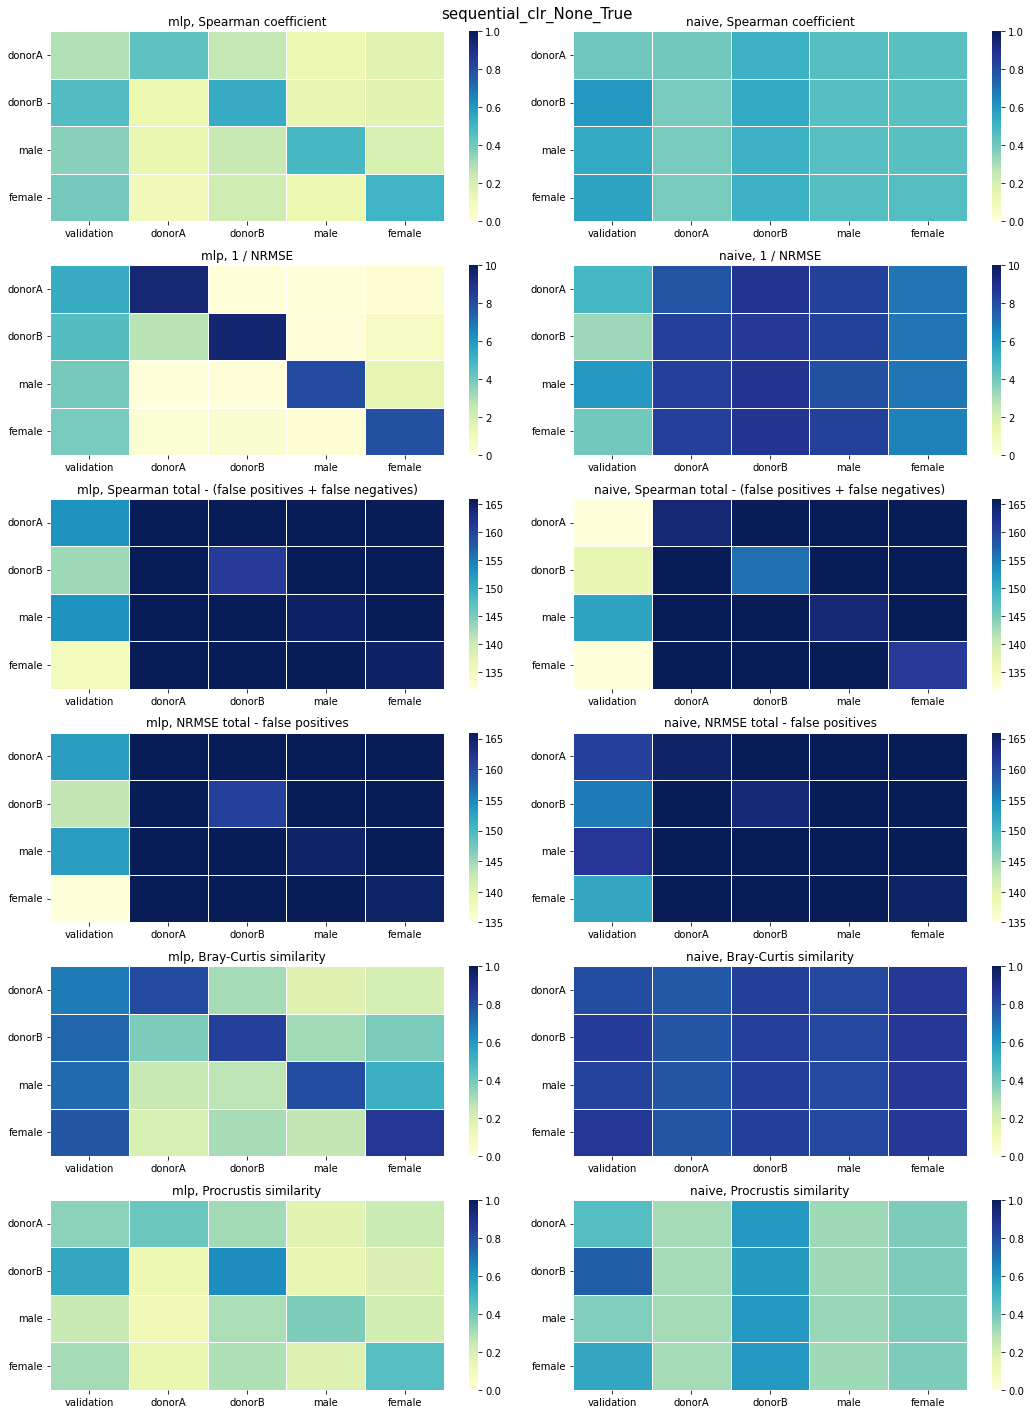

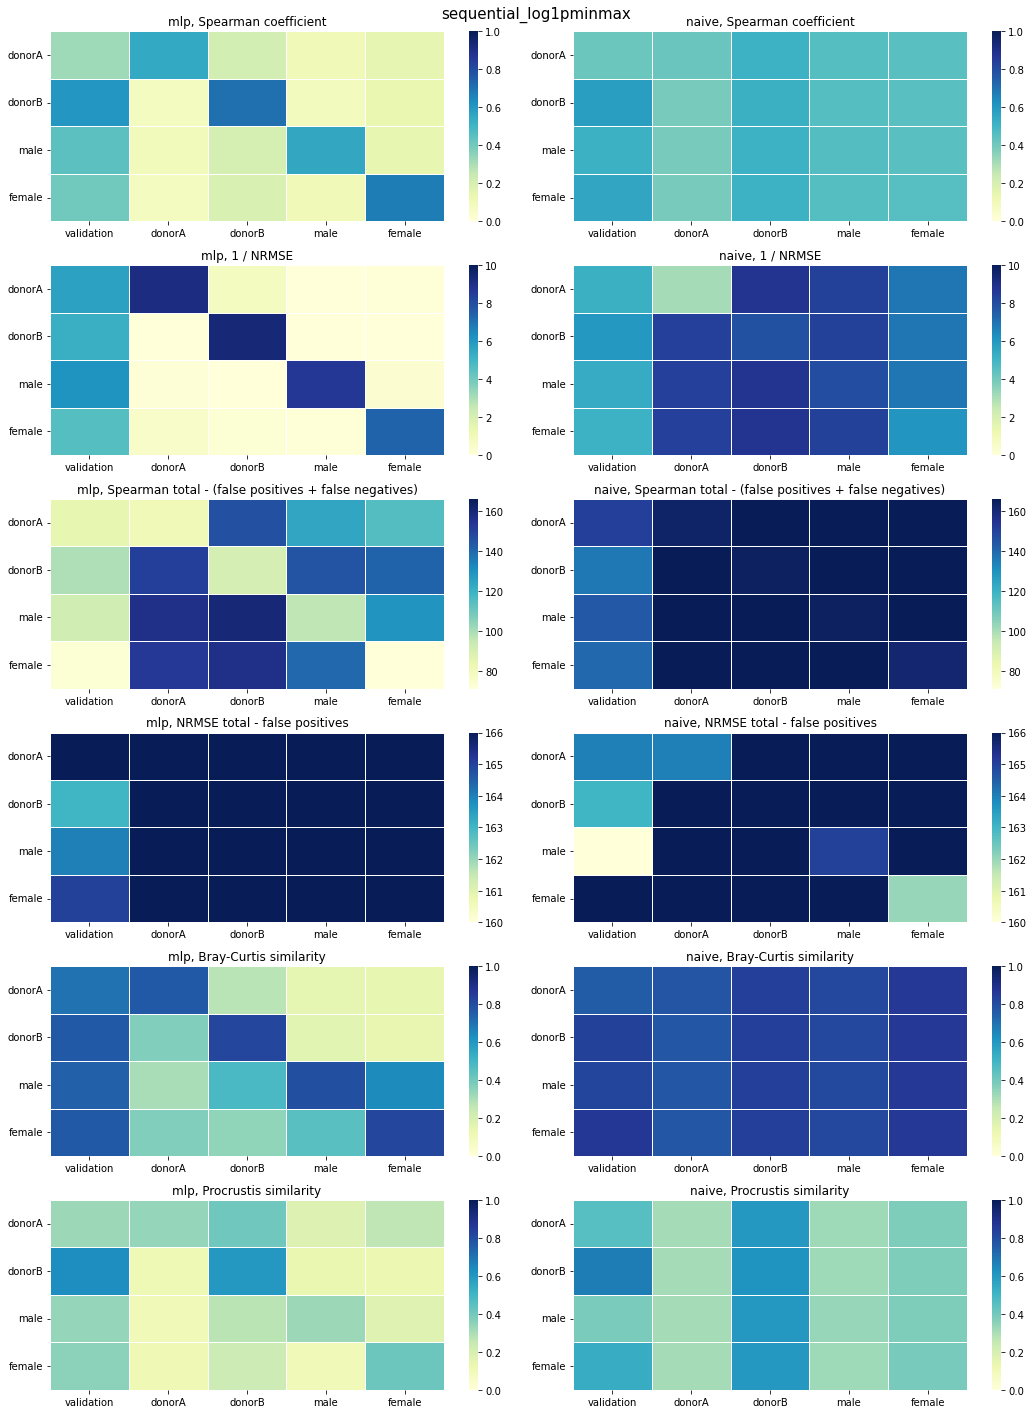

In [113]:
for input_type in INPUT_TYPES:
    for scaler in SCALERS:
        name = f"{input_type}_{scaler}"
        plt.figure(figsize=(15,20))
        for i, (k, v) in enumerate(plot_params.items()):
            plt.subplot(len(plot_params), 2, 2*i+1)
            # NRMSE mean / NaNs can be very different
            merged = np.concatenate([arrays[k][f'mlp_{name}'], arrays[k][f'naive_{name}']])
            if v['vmax'] == 'computed':
                vmax = np.ceil(np.max(merged))
            else:
                vmax = v['vmax']
            # NRMSE NaNs can be very different
            if v['vmin'] == 'computed':
                vmin = np.min(merged)
            else:
                vmin = v['vmin']
            ax = sns.heatmap(arrays[k][f'mlp_{name}'], vmin=vmin, vmax=vmax, **kwargs)
            ax.tick_params(axis='y', rotation=0)
            ax.set_title(f'mlp, {v["label"]}')
            plt.subplot(len(plot_params), 2, 2*i+2)
            ax = sns.heatmap(arrays[k][f'naive_{name}'], vmin=vmin, vmax=vmax, **kwargs)
            ax.tick_params(axis='y', rotation=0)
            ax.set_title(f'naive, {v["label"]}')
        plt.suptitle(name, fontsize=15)
        plt.tight_layout()
        plt.savefig(PLOT_PATH / f"{name}.png", dpi=200, facecolor='white')
        # plt.show()